<a href="https://colab.research.google.com/github/tvml/ml2425/blob/master/codici/loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Machine Learning 2025/2026  
## Laboratorio 3 — Ottimizzatori avanzati

**Docente:** Danilo Croce, Giorgio Gambosi


### Introduzione

Nel laboratorio precedente abbiamo introdotto i concetti fondamentali di **funzione di costo**, **rischio empirico** e **discesa del gradiente**.  
Abbiamo visto come il *gradient descent* — nelle sue varianti *batch*, *stochastic* e *mini-batch* — permetta di minimizzare il rischio empirico aggiornando iterativamente i parametri del modello nella direzione opposta al gradiente della funzione di costo.

Tuttavia, questi metodi di base presentano alcune **limitazioni pratiche**:
- convergenza lenta in presenza di superfici di costo irregolari o “vallate strette”;
- forte dipendenza dalla scelta del **learning rate**;
- difficoltà nel gestire funzioni di costo **non convesse**, tipiche delle reti neurali.

In questo laboratorio analizziamo una serie di **metodi di ottimizzazione avanzati**, nati per superare tali problemi.  
Questi algoritmi modificano o estendono la discesa del gradiente introducendo memoria, adattività e — nei casi più complessi — informazioni di ordine superiore (derivate seconde).

---

### Contenuti del laboratorio

1. **Metodo del Momento**  
   Introduce un termine di “inerzia” che tiene conto dei gradienti precedenti, riducendo le oscillazioni e accelerando la discesa.

2. **Accelerazione di Nesterov**  
   Variante del momento che anticipa la direzione di discesa, migliorando la stabilità e la convergenza.

3. **Adagrad**  
   Adatta il learning rate in modo automatico per ogni parametro, in base alla storia dei gradienti.

4. **RMSProp**  
   Smorza l’effetto di Adagrad mantenendo un tasso di apprendimento più stabile nel tempo.

5. **Adadelta**  
   Elimina la necessità di un learning rate fisso, rendendo l’adattamento completamente dinamico.

6. **Adam**  
   Combina momentum e adattività: è oggi l’ottimizzatore più utilizzato nel Deep Learning.

7. **Metodi del Secondo Ordine (Newton-Raphson)**  
   Utilizzano anche la matrice Hessiana per stimare curvature e direzioni di discesa più precise.

---

### Relazione con il laboratorio precedente

Il laboratorio precedente introduceva la **base teorica e computazionale** dell’ottimizzazione:  
- definizione del rischio empirico;  
- calcolo del gradiente tramite la *chain rule*;  
- implementazione delle forme base del *gradient descent*.  

Questo laboratorio ne rappresenta la **naturale estensione**, concentrandosi su come **migliorare la convergenza** e **stabilizzare l’apprendimento**.  
In altre parole, se il laboratorio 2 spiegava *come scendere la montagna*, il laboratorio 3 mostra *come farlo più velocemente e senza scivolare* 🧗‍♂️💨.

---

📌 **Obiettivo finale:** comprendere come la semplice idea del gradient descent possa essere raffinata in una famiglia di algoritmi potenti e flessibili, capaci di adattarsi automaticamente alla forma della funzione di costo e alle caratteristiche dei dati.

#### Criticità riguardo i metodi basati sulla discesa del gradiente

I metodi elementari di discesa del gradiente presentano alcune limitazioni:

- La scelta del **learning rate** $\eta$ è critica:  
  - troppo piccolo → convergenza lenta;  
  - troppo grande → oscillazioni o divergenza.  

- Possibili soluzioni:  
  - ridurre $\eta$ nel tempo (schema di *decay*);  
  - abbassarlo quando il miglioramento della funzione di costo è sotto una soglia.  
  ⚠️ Entrambe le soluzioni richiedono parametri fissati in anticipo e non si adattano automaticamente ai dati.  

- Un singolo $\eta$ per tutti i coefficienti può non essere ottimale.  

- Le funzioni di costo reali, soprattutto nelle **reti neurali**, sono non convesse e caratterizzate da molti **minimi locali** e **punti di sella**.  
  I metodi di base possono rimanere bloccati o avere difficoltà a uscire da queste situazioni.

In [ ]:
!wget https://tvml.github.io/ml2425/dataset/testSet.txt

--2025-10-23 21:02:16--  https://tvml.github.io/ml2425/dataset/testSet.txt
Resolving tvml.github.io (tvml.github.io)... 185.199.111.153, 185.199.109.153, 185.199.108.153, ...
Connecting to tvml.github.io (tvml.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2087 (2.0K) [text/plain]
Saving to: ‘testSet.txt’

testSet.txt         100%[===================>]   2.04K  --.-KB/s    in 0s      

2025-10-23 21:02:16 (35.1 MB/s) - ‘testSet.txt’ saved [2087/2087]



In [ ]:
# ===========================================================
# 📘 BLOCCO BASE — setup per i laboratori di ottimizzazione
# ===========================================================
# Ricrea tutto ciò che serve:
# - Dataset (X, t)
# - Funzioni di modello e costo
# - Gradiente e rischio empirico
# - Funzioni di visualizzazione
# ===========================================================

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time

# -----------------------------------------------------------
# 1️⃣ Dataset: caricamento o generazione sintetica
# -----------------------------------------------------------
try:
    # Se disponibile, carica il dataset originale
    data = np.loadtxt("testSet.txt")
    print("✅ Dataset 'testSet.txt' caricato correttamente.")
except FileNotFoundError:
    # Altrimenti, crea un dataset 2D sintetico ben separabile
    np.random.seed(0)
    n = 100
    X1 = np.random.randn(n, 2) + np.array([-2, 2])  # Classe 0
    X2 = np.random.randn(n, 2) + np.array([2, -2])  # Classe 1
    X = np.vstack((X1, X2))
    t = np.hstack((np.zeros(n), np.ones(n)))
    data = np.hstack((X, t.reshape(-1, 1)))
    print("⚠️ File non trovato: generato dataset sintetico (200 punti).")

# Separazione feature e target
X = data[:, 0:2]
t = data[:, 2].reshape(-1, 1)

# Aggiunge colonna di 1 per il bias
n, nfeatures = X.shape
X = np.hstack((np.ones((n, 1)), X))

# -----------------------------------------------------------
# 2️⃣ Modello: funzione sigmoide
# -----------------------------------------------------------
def f(theta, X):
    """Restituisce la probabilità stimata tramite la sigmoide."""
    z = np.dot(X, theta)
    return 1 / (1 + np.exp(-z))

# -----------------------------------------------------------
# 3️⃣ Funzione di costo (cross-entropy)
# -----------------------------------------------------------
def cost(theta, X, t, eps=1e-10):
    """
    Calcola la loss media (rischio empirico) per regressione logistica.
    Si usa eps per evitare log(0).
    """
    y = np.clip(f(theta, X), eps, 1 - eps)
    return -np.mean(t * np.log(y) + (1 - t) * np.log(1 - y))

# -----------------------------------------------------------
# 4️⃣ Gradiente del rischio empirico
# -----------------------------------------------------------
def gradient(theta, X, t):
    """
    ∇R_n(θ) = -(1/n) * Xᵀ (t - f(X; θ))
    """
    return -np.dot(X.T, (t - f(theta, X))) / len(X)

# -----------------------------------------------------------
# 5️⃣ Funzioni di visualizzazione
# -----------------------------------------------------------
def plot_ds(data, m=None, q=None):
    """
    Visualizza il dataset e, se forniti, la retta di separazione.
    Compatibile con pandas.DataFrame o np.ndarray.
    """
    fig = plt.figure(figsize=(10, 6))
    ax = plt.gca()

    # Se è un DataFrame
    if hasattr(data, "x1"):
        x_vals = np.linspace(data.x1.min()*1.1, data.x1.max()*1.1, 1000)
        ax.scatter(data[data.t==0].x1, data[data.t==0].x2, s=40, edgecolor='k', alpha=.7, label='Classe 0')
        ax.scatter(data[data.t==1].x1, data[data.t==1].x2, s=40, edgecolor='k', alpha=.7, label='Classe 1')
    # Se è un array NumPy
    else:
        x_vals = np.linspace(np.min(data[:,0])*1.1, np.max(data[:,0])*1.1, 1000)
        ax.scatter(data[data[:,2]==0][:,0], data[data[:,2]==0][:,1], s=40, edgecolor='k', alpha=.7, label='Classe 0')
        ax.scatter(data[data[:,2]==1][:,0], data[data[:,2]==1][:,1], s=40, edgecolor='k', alpha=.7, label='Classe 1')

    # Disegna la frontiera di decisione, se richiesta
    if (m is not None) and (q is not None):
        ax.plot(x_vals, m*x_vals + q, lw=2, color='black', label='Frontiera di decisione')

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Dataset e frontiera di decisione')
    ax.legend()
    plt.show()


def plot_all(cost_history, m, q, low=0, high=None, step=1):
    """
    Visualizza:
    - A sinistra: andamento del rischio empirico
    - A destra: traiettoria (m, q) durante l’ottimizzazione
    """
    if high is None:
        high = len(m)
    idx = range(low, high, step)
    ch = cost_history[idx].ravel()
    th1 = m[idx]
    th0 = q[idx]

    fig = plt.figure(figsize=(18, 6))

    # --- Andamento del costo ---
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(range(len(ch)), ch, linewidth=2, color='tab:blue')
    ax.set_xlabel('Iterazioni')
    ax.set_ylabel('Costo (rischio empirico medio)')
    ax.set_title('Andamento della funzione di costo')
    ax.xaxis.set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, pos: f'{x*step+low:0.0f}')
    )

    # --- Traiettoria (m, q) ---
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(th0, th1, linewidth=2, color='tab:orange', alpha=0.8)
    ax.scatter(th0[-1], th1[-1], color='red', marker='o', s=50, label='Punto finale')
    ax.set_xlabel(r'Intercetta $q$')
    ax.set_ylabel(r'Pendenza $m$')
    ax.set_title('Traiettoria dei parametri $(m, q)$')
    ax.legend()

    plt.tight_layout()
    plt.show()


def near_opt(m, min_dist=1e-2, ge_per_step=1):
    """
    Determina l’iterazione in cui la pendenza m converge
    entro una certa soglia (min_dist).
    """
    for i in range(1, len(m)):
        if abs(m[i] - m[i - 1]) < min_dist:
            print(f"Convergenza raggiunta al passo {i} ({i * ge_per_step} gradienti calcolati)")
            break

✅ Dataset 'testSet.txt' caricato correttamente.


## ⚙️ Prima di iniziare... Note tecniche

In questo laboratorio utilizzeremo **varianti del Gradient Descent** (GD) per ottimizzare la regressione logistica.  
A seconda del metodo considerato, gli aggiornamenti dei parametri possono essere eseguiti in modalità:

- **Batch Gradient Descent (BGD)** → il gradiente è calcolato sull’intero dataset ad ogni passo;  
- **Stochastic Gradient Descent (SGD)** → il gradiente è stimato su un singolo campione;  
- **Mini-Batch Gradient Descent** → compromesso tra i due (non usato esplicitamente in questo laboratorio).

👉 Tutti gli ottimizzatori implementati qui (Momentum, Nesterov, Adagrad, RMSProp, Adadelta, Adam, Newton-Raphson) operano in **modalità Batch**,  
ossia calcolano il gradiente medio su tutti gli esempi a ogni iterazione.

Infine, il numero massimo di iterazioni viene controllato tramite la variabile globale `epochs`, che è possibile modificare nel blocco Python seguente per uniformare gli esperimenti.

In [ ]:
# ===========================================================
# ⚙️ Impostazioni generali per gli esperimenti di ottimizzazione
# ===========================================================
# - Tutti i metodi utilizzano il Batch Gradient Descent (BGD)
#   → il gradiente è calcolato sull’intero dataset a ogni passo.
# - Se desiderato, si puo' modificare le funzioni per usare lo
#   Stochastic o Mini-Batch Gradient Descent.
# - 'epochs' controlla il numero massimo di iterazioni (passi).
#   Modificando questa variabile, aggiorni tutti gli esperimenti.
# ===========================================================

epochs = 100  # Numero di epoche (iterazioni) per ogni algoritmo

### 🌀 Metodo del Momento (Momentum)

I metodi di discesa del gradiente visti finora possono diventare **inefficienti** quando la funzione di costo varia in modo molto diverso lungo direzioni diverse. Ad esempio, se la superficie del rischio empirico è una “vallata” allungata, gli aggiornamenti oscillano trasversalmente e convergono lentamente verso il minimo.

Per rendere la discesa più fluida, il **metodo del momento** introduce un concetto ispirato alla fisica: l’aggiornamento dei parametri è visto come il **moto di un corpo soggetto a inerzia** che scivola sulla superficie della funzione di costo $\mathscr{R}(\theta)$.

---

#### ⚙️ Idea fisica

Immagina che il vettore dei parametri $\theta$ rappresenti la **posizione** di una particella.  
Il gradiente $\nabla_\theta \mathscr{R}(\theta)$ agisce come una **forza** che la spinge verso il basso (verso il minimo).  
L’inerzia fa sì che, invece di fermarsi bruscamente, la particella **mantenga parte della velocità accumulata** nei passi precedenti.  
Il parametro $\gamma$ gioca il ruolo di **attrito**, regolando quanto della velocità precedente viene mantenuto.

---

#### 🧮 Formulazione matematica

Definiamo un vettore di **velocità** $v^{(k)}$, che rappresenta lo spostamento di $\theta$ al passo $k$:

$$
\begin{aligned}
v^{(k+1)} &= \gamma \, v^{(k)} - \eta \sum_{i=1}^n \nabla_\theta \mathscr{R}(\theta^{(k)}; x_i) \\
\theta^{(k+1)} &= \theta^{(k)} + v^{(k+1)}
\end{aligned}
$$

dove:
- $\eta$ è il **learning rate**;  
- $\gamma \in [0,1)$ è il **fattore di momento**, che controlla quanta parte della velocità precedente viene mantenuta.

---

#### 🔍 Interpretazione

- Se $\gamma = 0$, il metodo si riduce alla discesa del gradiente standard.  
- Se $\gamma > 0$, parte della direzione di aggiornamento precedente viene **conservata**, creando un effetto di **accelerazione** nelle direzioni coerenti del gradiente.  
- Se il gradiente cambia spesso direzione, l’inerzia tende a **smorzare le oscillazioni**, rendendo la discesa più stabile.

---

#### 📈 In sintesi

| Parametro | Significato | Effetto |
|------------|-------------|----------|
| $\eta$ | Learning rate | Controlla la velocità di aggiornamento |
| $\gamma$ | Fattore di momento | Controlla quanta “memoria” dei passi precedenti si mantiene |
| $v^{(k)}$ | Velocità | Direzione e intensità dello spostamento corrente |
| $\theta^{(k)}$ | Parametri | Posizione attuale nel paesaggio del rischio |

---

#### 🔹 Interpretazione vettoriale e aggiornamento ricorsivo

Mentre
$$
\theta^{(k)} = (\theta_1^{(k)}, \ldots, \theta_d^{(k)})^T
$$
rappresenta la **posizione** dei parametri al passo $k$,  
il vettore
$$
v^{(k)} = (v_1^{(k)}, \ldots, v_d^{(k)})^T
$$
rappresenta la **velocità di aggiornamento** che trasporta $\theta^{(k)}$ verso $\theta^{(k+1)}$.

---

#### 🔹 Dipendenza dai gradienti passati

L’aggiornamento può essere riscritto in forma esplicita per mostrare come ogni passo dipenda **dai gradienti calcolati in tutte le iterazioni precedenti**,  
con un peso che **decresce esponenzialmente** nel tempo in base a $\gamma$.  
Assumendo $v^{(0)} = 0$:

$$
\theta^{(k+1)}
= \theta^{(k)} - \eta \left( \sum_{j=0}^k \gamma^j \sum_{i=1}^n \nabla_\theta \mathscr{R}(\theta^{(k-j)}; \mathbf{x}_i) \right)
$$

Ogni aggiornamento di $\theta$ tiene quindi conto **della storia dei gradienti**, il cui effetto diminuisce nel tempo con fattore $\gamma^j$.

---

#### 🔹 Applicazione alla Regressione Logistica

Nel caso della **regressione logistica**, il gradiente della funzione di costo è proporzionale all’errore di predizione $(t_i - f(\mathbf{x}_i; \theta))$.  
Applicando la regola del momento, gli aggiornamenti diventano:

$$
\begin{aligned}
v_j^{(k+1)} &= \gamma v_j^{(k)} + \frac{\eta}{n} \sum_{i=1}^n (t_i - f(\mathbf{x}_i; \theta)) x_{ij}, \quad j = 1, \ldots, d \\
v_0^{(k+1)} &= \gamma v_0^{(k)} + \frac{\eta}{n} \sum_{i=1}^n (t_i - y_i) \\
\theta_j^{(k+1)} &= \theta_j^{(k)} + v_j^{(k+1)}, \quad j = 0, \ldots, d
\end{aligned}
$$

---

#### 💡 Conclusione

- $v$ rappresenta la **velocità di aggiornamento**, che integra informazione storica dei gradienti.  
- $\gamma$ controlla **quanto del passato** viene mantenuto: valori più alti implicano più inerzia.  
- Ogni passo combina i gradienti precedenti con un effetto di **memoria esponenzialmente decrescente**, permettendo una convergenza **più rapida e stabile**.

### ⚙️ Varianti del Metodo del Momento e Segni degli Aggiornamenti

Il **metodo del momento** può essere implementato in diverse modalità, a seconda di **quanti esempi del dataset vengono usati per calcolare il gradiente ad ogni passo**.  
Il principio rimane lo stesso: si accumula una **velocità vettoriale** `v`, che tiene memoria della direzione di discesa.

---

#### 🔹 1️⃣ Batch Momentum

Nel **Batch Momentum**, ad ogni epoca si calcola il **gradiente medio** sull’intero dataset:

$$
v^{(k+1)} = \gamma v^{(k)} - \eta \, \nabla_\theta \overline{\mathscr{R}}(\theta^{(k)})
$$
$$
\theta^{(k+1)} = \theta^{(k)} + v^{(k+1)}
$$

Pseudocodice:

```
v = 0
for epoch in range(n_epochs):
    g = 0
    for k in range(dataset_size):
        g = g + evaluate_gradient(loss_function, theta, X[k])
    g = g / dataset_size          # gradiente medio
    v = gamma * v - eta * g       # aggiornamento della velocità
    theta = theta + v             # aggiornamento dei parametri
```

---

#### 🔹 2️⃣ Stochastic Momentum (SGD + Momentum)

Nel caso **stocastico**, ad ogni iterazione si utilizza **un solo campione (o mini-batch)** per stimare il gradiente.  
Il vantaggio è una maggiore velocità, ma con oscillazioni più evidenti:

```
v = 0
for epoch in range(n_epochs):
    for k in range(dataset_size):
        g = evaluate_gradient(loss_function, theta, X[k])
        v = gamma * v - eta * g
        theta = theta + v
```

---

#### 🔹 3️⃣ Interpretazione del segno

Nel termine di aggiornamento:

$$
v^{(k+1)} = \gamma v^{(k)} - \eta \, \nabla_\theta \mathscr{R}(\theta^{(k)})
$$

- Il segno **“−”** davanti al gradiente serve perché vogliamo **muoverci nella direzione opposta** al gradiente, ossia verso il minimo.  
- `v` memorizza la **direzione media di discesa**: se i gradienti successivi puntano nella stessa direzione, la velocità aumenta; se puntano in direzioni opposte, la velocità si attenua.

---

#### 🔹 4️⃣ Ruolo del parametro γ (gamma)

Il parametro **γ ∈ [0,1)** determina **quanto del passo precedente viene mantenuto**:

| γ | Significato | Effetto pratico |
|:--:|:-------------|:----------------|
| 0 | nessuna memoria → discesa del gradiente standard | Aggiornamenti lenti, ma stabili |
| 0.5–0.9 | memoria moderata | Convergenza più rapida |
| >0.9 | forte inerzia | Rischio di overshooting o oscillazioni |

---

#### 💡 In sintesi

- `v` rappresenta una **media pesata dei gradienti passati** → effetto di inerzia.  
- Il termine `γ v` **mantiene una frazione della velocità precedente**.  
- Il termine `−η ∇R(θ)` **spinge nella direzione opposta al gradiente**.  
- L’aggiornamento finale `θ = θ + v` sposta i parametri **verso il minimo**, seguendo la direzione “smussata” nel tempo.

In [ ]:
def momentum_gd(X, t, eta=0.1, gamma=0.9, epochs=1000):
    """
    Implementazione del metodo del Momento (Momentum Gradient Descent)
    per la regressione logistica.

    Parametri
    ----------
    X : ndarray di forma (n, d+1)
        Matrice delle feature (inclusa la colonna di bias).
    t : ndarray di forma (n, 1)
        Vettore dei target binari {0,1}.
    eta : float, default=0.1
        Learning rate (ampiezza del passo).
    gamma : float, default=0.9
        Fattore di momento: controlla quanta "velocità" passata si conserva.
    epochs : int, default=1000
        Numero di iterazioni dell’algoritmo.

    Ritorna
    -------
    cost_history : ndarray
        Valori della funzione di costo per ogni epoca.
    m, q : ndarray
        Coefficienti (pendenza e intercetta) stimati a ogni passo,
        utili per la visualizzazione nel caso bidimensionale.
    """

    n_features = X.shape[1]
    theta = np.zeros((n_features, 1))       # Parametri iniziali (incluso bias)
    v = np.zeros_like(theta)                # Velocità iniziale (stessa forma di theta)

    cost_history = []
    theta_history = []

    for epoch in range(epochs):
        # Calcolo del gradiente (discesa del rischio empirico medio)
        g = gradient(theta, X, t)

        # Aggiornamento della velocità con il termine di momento
        v = gamma * v - eta * g

        # Aggiornamento dei parametri
        theta = theta + v

        # Registrazione della traiettoria e del costo
        theta_history.append(theta.copy())
        cost_history.append(cost(theta, X, t))

    # Conversione in array per analisi successive
    theta_history = np.array(theta_history).reshape(-1, n_features)
    cost_history = np.array(cost_history).reshape(-1, 1)

    # Estrazione pendenza (m) e intercetta (q) nel caso 2D
    if n_features == 3:  # bias + 2 feature
        m = -theta_history[:, 1] / theta_history[:, 2]
        q = -theta_history[:, 0] / theta_history[:, 2]
    else:
        m, q = None, None

    return cost_history, m, q

Avvio ottimizzazione con Momentum Gradient Descent...
Tempo di esecuzione:  0.016 secondi
Numero di passi totali: 100
Gradienti calcolati: 10000


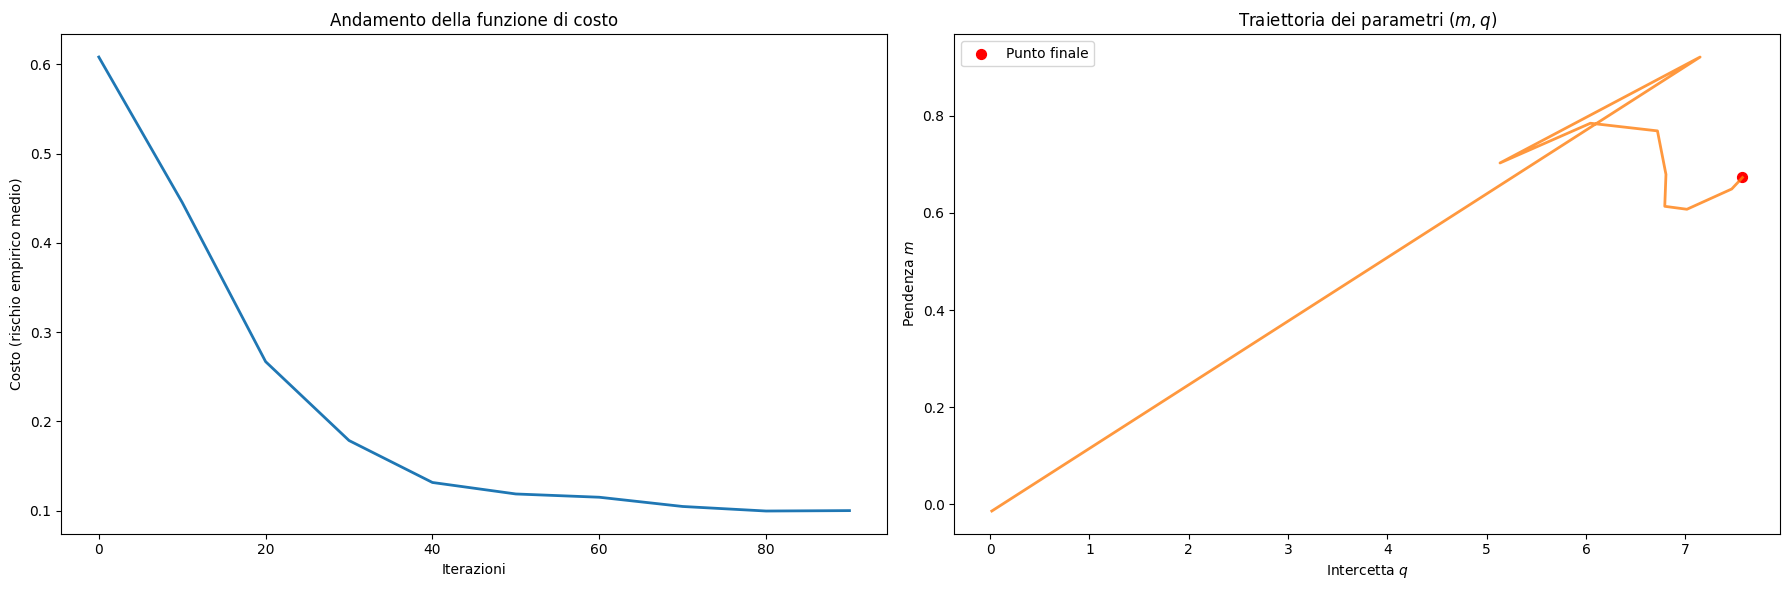

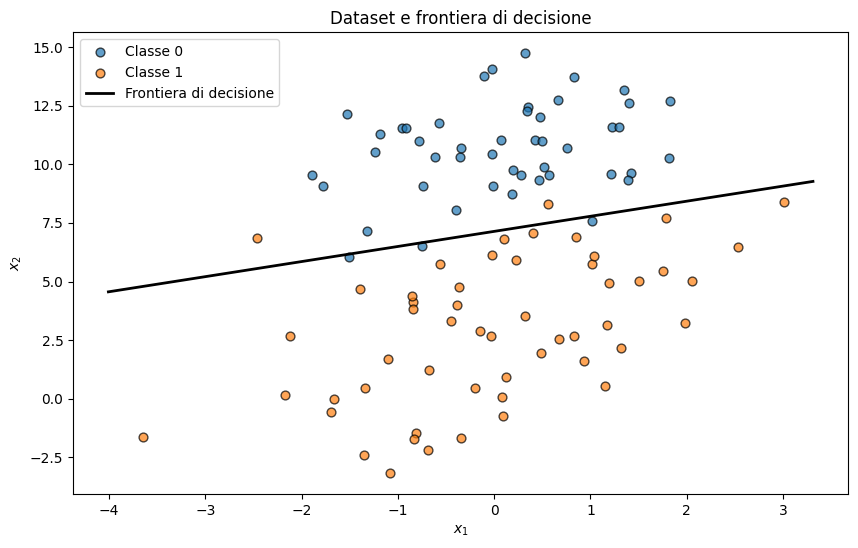

In [ ]:
# ===========================================================
# Esecuzione: Metodo del Momento (Momentum Gradient Descent)
# ===========================================================

print("Avvio ottimizzazione con Momentum Gradient Descent...")

start_time = time.time()
cost_mom, m_mom, q_mom = momentum_gd(X, t, eta=0.1, gamma=0.97, epochs=epochs)
elapsed_time = time.time() - start_time

# -----------------------------------------------------------
# Report sintetico
# -----------------------------------------------------------
print(f"Tempo di esecuzione: {elapsed_time:6.3f} secondi")
if m_mom is not None:
    print(f"Numero di passi totali: {len(m_mom)}")
    print(f"Gradienti calcolati: {len(m_mom) * n}")
else:
    print(f"Iterazioni totali: {len(cost_mom)}")

# -----------------------------------------------------------
# Visualizzazione dei risultati
# -----------------------------------------------------------
low, high, step = 0, len(cost_mom), 10
plot_all(cost_mom, m_mom, q_mom, low, high, step)

plot_ds(data, m_mom[-1], q_mom[-1])

### ⚡ Accelerazione del Gradiente di Nesterov (Nesterov Momentum)

Il metodo di **Nesterov** nasce come una raffinata estensione del **metodo del momento**.  
L’idea chiave è introdurre un *“passo di anticipo”* (*look-ahead*): invece di calcolare il gradiente nel punto corrente, lo si valuta **in una posizione predetta** più avanti lungo la direzione di velocità attuale.

---

#### 🔹 Intuizione di base

Nel metodo del momento, conosciamo al passo $k$:
- la **posizione attuale** $\theta^{(k)}$  
- la **velocità accumulata** $v^{(k)}$

Da queste possiamo stimare dove ci troveremmo **se facessimo un passo in avanti** mantenendo la stessa velocità:

$$
\tilde{\theta}^{(k+1)} = \theta^{(k)} + \gamma v^{(k)}
$$

Questa è una **posizione “predetta”** (*look-ahead*), una sorta di anteprima del passo successivo.

---

#### 🔹 Idea chiave di Nesterov

Nel **Momentum classico**, il gradiente viene calcolato nel punto corrente $\theta^{(k)}$:

$$
v^{(k+1)} = \gamma v^{(k)} - \eta \, \nabla_\theta \mathscr{R}(\theta^{(k)})
$$

In **Nesterov Momentum**, invece, il gradiente viene calcolato **nel punto anticipato** $\tilde{\theta}^{(k)} = \theta^{(k)} + \gamma v^{(k)}$:


\begin{aligned}
v^{(k+1)} &= \gamma v^{(k)} - \eta \, \nabla_\theta \mathscr{R}(\tilde{\theta}^{(k)}) \\
\theta^{(k+1)} &= \theta^{(k)} + v^{(k+1)}
\end{aligned}

---

#### 🔹 Interpretazione geometrica

- Invece di “muoversi alla cieca” lungo il gradiente nel punto corrente,  
  Nesterov **guarda leggermente avanti** per valutare come cambierà la funzione di costo.  
- Questo permette di **correggere la direzione prima di eseguire il passo**, evitando eccessive oscillazioni.

---

#### 🔹 Confronto con il Momentum classico

| Metodo | Punto in cui viene calcolato il gradiente | Effetto |
|---------|-------------------------------------------|----------|
| Momentum | $\theta^{(k)}$ | Lento ad adattarsi alle variazioni del gradiente |
| Nesterov | $\theta^{(k)} + \gamma v^{(k)}$ | Anticipa la direzione → più stabile e rapido |

---

#### 🔹 Forma espansa (dipendenza dai gradienti passati)

Partendo da:
$$
\theta^{(k+1)} = \theta^{(k)} + v^{(k+1)} = \theta^{(k)} + \gamma v^{(k)} - \eta \nabla_\theta \mathscr{R}(\tilde{\theta}^{(k)})
$$
possiamo osservare che il nuovo aggiornamento **anticipa** il contributo del gradiente,  
ottenendo così un movimento più “intelligente” verso il minimo.

---

#### 💡 In sintesi

- Nesterov valuta il gradiente **in anticipo**, prevedendo dove il parametro si troverà dopo il prossimo passo.  
- Questo migliora la **stabilità** e accelera la **convergenza** rispetto al Momentum classico.  
- In pratica, combina **inerzia** (come nel momento) e **correzione predittiva** (look-ahead).

---

![Confronto tra Momentum e Nesterov Momentum.](https://tvml.github.io/ml2425/codici/assets/nesterov.png)

```python
v = 0
for i in range(n_epochs):
    g = 0
    theta_approx = theta+gamma*v
    for k in range(dataset_size):
        g = g+evaluate_gradient(loss_function, theta_approx, X[k])
    v = gamma*v-eta*g
    theta = theta+v
```

In [ ]:
def nesterov_gd(X, t, eta=0.1, gamma=0.97, epochs=1000):
    """
    Implementazione del metodo di Nesterov Accelerated Gradient (NAG).

    Parametri
    ----------
    X : ndarray di forma (n, d+1)
        Matrice delle feature (inclusa la colonna di bias).
    t : ndarray di forma (n, 1)
        Vettore dei target binari {0,1}.
    eta : float, default=0.1
        Learning rate.
    gamma : float, default=0.97
        Fattore di momento.
    epochs : int, default=1000
        Numero di iterazioni dell'algoritmo.

    Ritorna
    -------
    cost_history : ndarray
        Valori della funzione di costo per ogni epoca.
    m, q : ndarray
        Coefficienti della retta di separazione (solo per caso 2D).
    """

    n_features = X.shape[1]
    theta = np.zeros((n_features, 1))
    v = np.zeros_like(theta)
    theta_history = []
    cost_history = []

    for epoch in range(epochs):
        # "Look-ahead": valutazione del gradiente nel punto previsto
        g = gradient(theta + gamma * v, X, t)

        # Aggiornamento della velocità e dei parametri
        v = gamma * v - eta * g
        theta = theta + v

        # Salvataggio traiettoria e costo
        theta_history.append(theta.copy())
        cost_history.append(cost(theta, X, t))

    # Conversione in array
    theta_history = np.array(theta_history).reshape(-1, n_features)
    cost_history = np.array(cost_history).reshape(-1, 1)

    # Calcolo m, q per visualizzazione (caso 2D)
    if n_features == 3:
        m = -theta_history[:, 1] / theta_history[:, 2]
        q = -theta_history[:, 0] / theta_history[:, 2]
    else:
        m, q = None, None

    return cost_history, m, q

Avvio ottimizzazione con Nesterov Accelerated Gradient...
Tempo di esecuzione:  0.013 secondi
Numero di passi totali: 100
Gradienti calcolati: 10000


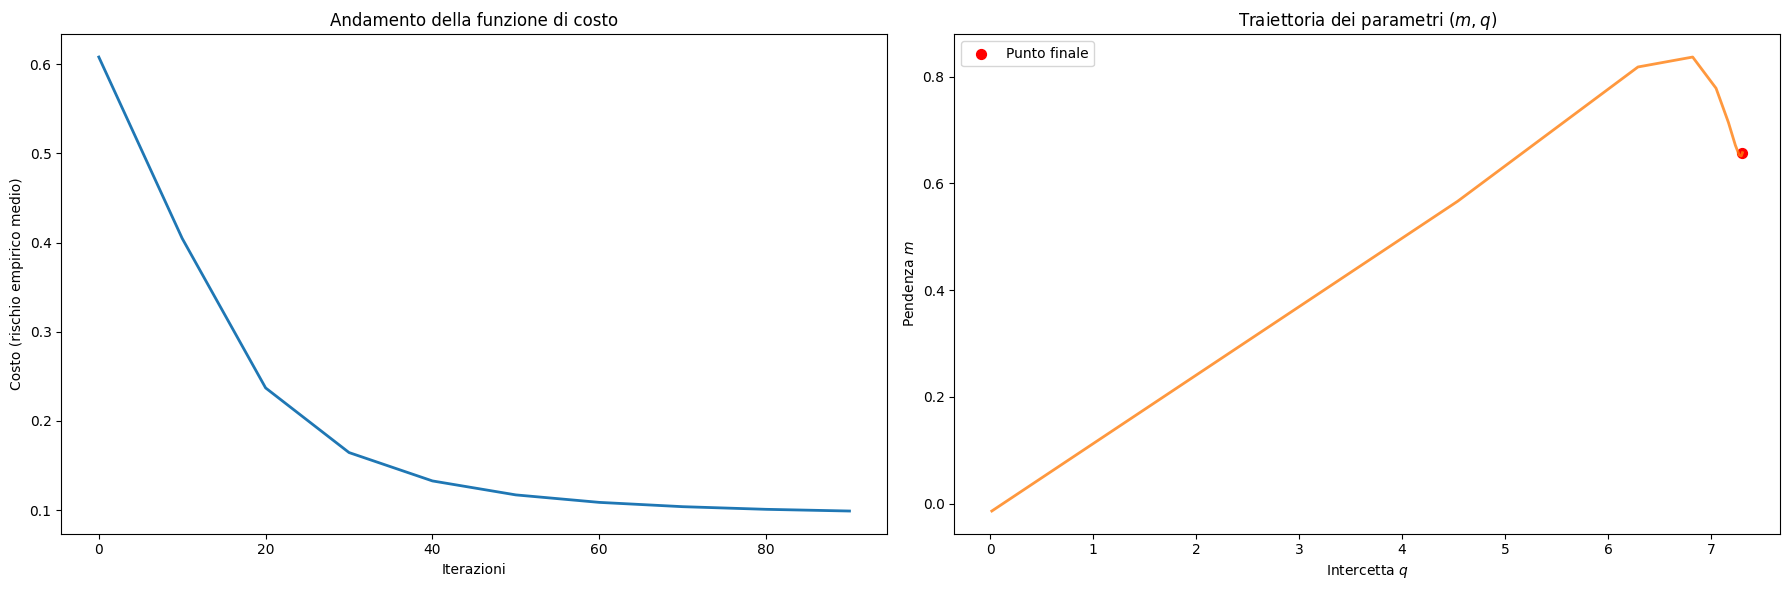

Convergenza raggiunta al passo 1 (100 gradienti calcolati)


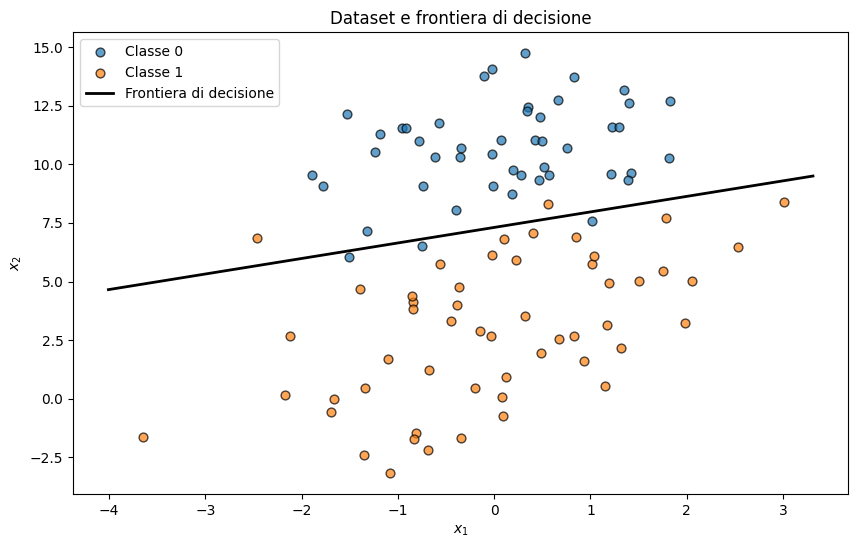

In [ ]:
# ===========================================================
# Esecuzione: Metodo di Nesterov (Accelerated Gradient)
# ===========================================================

print("Avvio ottimizzazione con Nesterov Accelerated Gradient...")

start_time = time.time()
cost_nag, m_nag, q_nag = nesterov_gd(X, t, eta=0.1, gamma=0.97, epochs=epochs)
elapsed_time = time.time() - start_time

# -----------------------------------------------------------
# Report sintetico
# -----------------------------------------------------------
print(f"Tempo di esecuzione: {elapsed_time:6.3f} secondi")
if m_nag is not None:
    print(f"Numero di passi totali: {len(m_nag)}")
    print(f"Gradienti calcolati: {len(m_nag) * n}")
else:
    print(f"Iterazioni totali: {len(cost_nag)}")

# -----------------------------------------------------------
# Visualizzazione dei risultati
# -----------------------------------------------------------
low, high, step = 0, len(cost_nag), 10
plot_all(cost_nag, m_nag, q_nag, low, high, step)

near_opt(m_nag, min_dist=1e-1, ge_per_step=n)

plot_ds(data, m_nag[-1], q_nag[-1])

### ⚙️ Adagrad — Adaptive Gradient Descent

Il metodo **Adagrad** (*Adaptive Gradient Descent*) introduce un’idea chiave:  
ogni parametro del modello ottiene il **proprio learning rate**, che si **adatta nel tempo** in base alla storia dei gradienti.

---

#### 🔹 Motivazione

Nella *gradient descent* standard, tutti i parametri $\theta_j$ vengono aggiornati con lo stesso learning rate $\eta$:

$$
\theta_j^{(k+1)} = \theta_j^{(k)} - \eta \,
\frac{\partial \mathscr{R}(\theta)}{\partial \theta_j}\Big|_{\theta=\theta^{(k)}}
$$

Ma nella pratica:
- alcuni parametri hanno gradienti **molto grandi** → cambiano troppo rapidamente;  
- altri hanno gradienti **molto piccoli** → si aggiornano troppo lentamente.

Un singolo $\eta$ non può adattarsi a entrambe le situazioni.  
Adagrad nasce per **correggere questo squilibrio**.

---

#### 🔹 Idea di base

L’algoritmo tiene traccia, per ciascun parametro $\theta_j$, della **somma cumulativa dei quadrati dei gradienti**:

$$
G_{j,k} = \sum_{i=1}^{k} g_{j,i}^2,
\qquad
g_{j,i} = \frac{\partial \mathscr{R}(\theta)}{\partial \theta_j}\Big|_{\theta=\theta^{(i)}}.
$$

Questa quantità misura *quanto intensamente* ogni parametro è stato aggiornato nel passato.

---

#### 🔹 Learning rate adattivo

Il learning rate effettivo per il parametro $\theta_j$ diventa:

$$
\eta_j^{(k)} = \frac{\eta}{\sqrt{G_{j,k} + \varepsilon}}
$$

dove:
- $\eta$ è il learning rate di base,  
- $\varepsilon$ (es. $10^{-8}$) evita divisioni per zero e stabilizza il calcolo.

Parametri con gradienti grandi → $G_{j,k}$ grande → $\eta_j^{(k)}$ piccolo.  
Parametri con gradienti piccoli → $G_{j,k}$ piccolo → $\eta_j^{(k)}$ grande.

---

#### 🔹 Aggiornamento dei parametri

L’equazione di aggiornamento diventa:

$$
\theta_j^{(k+1)} = \theta_j^{(k)}
- \frac{\eta}{\sqrt{G_{j,k} + \varepsilon}} \, g_{j,k}
$$

oppure, in forma **vettoriale compatta** (operazioni elemento per elemento):

$$
\theta^{(k+1)}
= \theta^{(k)} - \eta \,
\frac{g^{(k)}}{\sqrt{G^{(k)}} + \varepsilon}.
$$

---

#### 🔹 Interpretazione intuitiva

Adagrad “ricorda” i gradienti passati:
- se un parametro ha ricevuto gradienti grandi spesso → il suo passo si **riduce**;  
- se ha ricevuto gradienti piccoli o rari → il suo passo resta **più ampio**.  

In questo modo, il metodo si adatta **alla scala e alla frequenza** delle feature,  
rendendolo particolarmente efficace in problemi **sparsi** (es. NLP).

---

#### 🔹 Limite del metodo

Poiché $G_{j,k}$ cresce monotonamente (è una somma di termini positivi),
il denominatore aumenta nel tempo → il learning rate tende a **zero**.

Effetti pratici:
- inizialmente Adagrad converge **molto rapidamente**;  
- ma dopo molte iterazioni i passi diventano **troppo piccoli**,  
  e l’ottimizzazione può **bloccarsi prematuramente**.

---

#### 💡 In sintesi

| Concetto | Significato |
|-----------|-------------|
| $G_{j,k}$ | Somma cumulativa dei quadrati dei gradienti del parametro $j$ |
| $\eta_j^{(k)}$ | Learning rate adattivo (decrescente nel tempo) |
| $\varepsilon$ | Costante di stabilizzazione numerica |
| ✅ Vantaggio | Adattamento automatico del passo per ogni direzione |
| ⚠️ Limite | Learning rate che tende a zero nel lungo periodo |

---

In pratica, **Adagrad** è ottimo per:
- feature con scale molto diverse,
- dati sparsi (es. parole rare nei modelli NLP).

Ma, poiché il passo decresce troppo nel tempo, è stato poi esteso nei metodi **RMSProp** e **Adam**, che introducono meccanismi di *decadimento controllato* per mantenere il learning rate efficace più a lungo.

In [ ]:
def adagrad(X, t, eta=0.1, eps=1e-8, epochs=1000):
    """
    Implementazione dell'ottimizzatore Adagrad.

    Adagrad adatta dinamicamente il learning rate per ogni parametro,
    riducendolo per le dimensioni in cui il gradiente è stato grande in passato
    e mantenendolo alto dove i gradienti sono stati piccoli.

    Parametri
    ----------
    X : ndarray di forma (n, d+1)
        Matrice delle feature (inclusa la colonna di bias).
    t : ndarray di forma (n, 1)
        Vettore dei target binari {0,1}.
    eta : float, default=0.1
        Learning rate di base.
    eps : float, default=1e-8
        Piccola costante per evitare divisioni per zero.
    epochs : int, default=1000
        Numero di iterazioni dell'algoritmo.

    Ritorna
    -------
    cost_history : ndarray
        Valori della funzione di costo per ogni epoca.
    m, q : ndarray
        Coefficienti della retta di separazione (solo per caso 2D).
    """

    n_features = X.shape[1]
    theta = np.zeros((n_features, 1))
    G = np.zeros_like(theta)  # accumulatore dei quadrati dei gradienti
    theta_history = []
    cost_history = []

    for epoch in range(epochs):
        g = gradient(theta, X, t)
        G += g**2  # accumula la somma dei quadrati dei gradienti
        theta -= eta * g / (np.sqrt(G) + eps)

        theta_history.append(theta.copy())
        cost_history.append(cost(theta, X, t))

    theta_history = np.array(theta_history).reshape(-1, n_features)
    cost_history = np.array(cost_history).reshape(-1, 1)

    # Calcolo m, q per la visualizzazione nel caso bidimensionale
    if n_features == 3:
        m = -theta_history[:, 1] / theta_history[:, 2]
        q = -theta_history[:, 0] / theta_history[:, 2]
    else:
        m, q = None, None

    return cost_history, m, q

Avvio ottimizzazione con Adagrad...
Tempo di esecuzione:  0.014 secondi
Numero di passi totali: 100
Gradienti calcolati: 10000


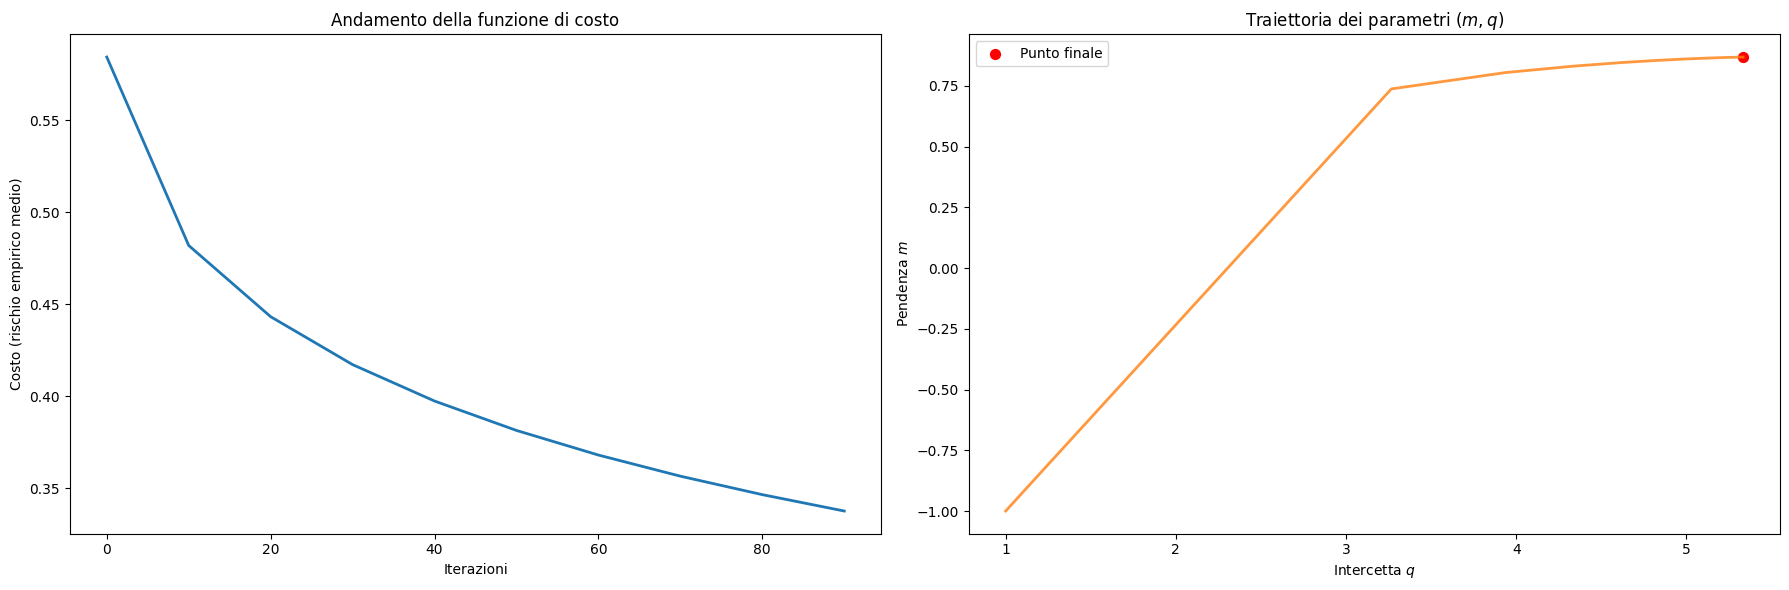

Convergenza raggiunta al passo 5 (500 gradienti calcolati)


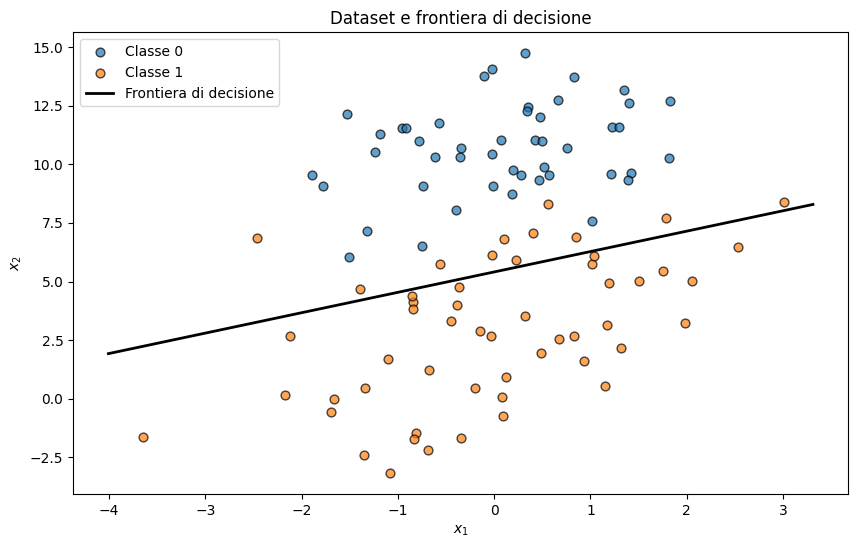

In [ ]:
# ===========================================================
# Esecuzione: Adagrad
# ===========================================================

print("Avvio ottimizzazione con Adagrad...")

start_time = time.time()
cost_ada, m_ada, q_ada = adagrad(X, t, eta=0.1, eps=1e-8, epochs=epochs)
elapsed_time = time.time() - start_time

# -----------------------------------------------------------
# Report sintetico
# -----------------------------------------------------------
print(f"Tempo di esecuzione: {elapsed_time:6.3f} secondi")
if m_ada is not None:
    print(f"Numero di passi totali: {len(m_ada)}")
    print(f"Gradienti calcolati: {len(m_ada) * n}")
else:
    print(f"Iterazioni totali: {len(cost_ada)}")

# -----------------------------------------------------------
# Visualizzazione dei risultati
# -----------------------------------------------------------
low, high, step = 0, len(cost_ada), 10
plot_all(cost_ada, m_ada, q_ada, low, high, step)

near_opt(m_ada, min_dist=1e-1, ge_per_step=n)

plot_ds(data, m_ada[-1], q_ada[-1])

### RMSProp

### ⚙️ RMSProp — Root Mean Square Propagation

Il metodo **RMSProp** nasce per risolvere un limite importante di **Adagrad**:  in Adagrad, la somma cumulativa dei quadrati dei gradienti cresce continuamente, facendo sì che il learning rate diminuisca **monotonicamente fino quasi ad annullarsi**.  

RMSProp introduce una **media mobile esponenziale** dei gradienti al posto della somma totale, così da mantenere un equilibrio tra adattività e stabilità.

---

#### 🔹 Idea principale

In Adagrad, il termine cumulativo era:

$$
G_{j,k} = \sum_{i=0}^{k} g_{j,i}^2
$$

che cresce indefinitamente nel tempo.  
RMSProp sostituisce questa somma con una **media pesata dei gradienti recenti**,  
dove i contributi passati **decadono esponenzialmente** grazie a un parametro di smorzamento $\gamma$:

$$
\tilde{G}_{j,k} = \gamma \, \tilde{G}_{j,k-1} + (1 - \gamma) g_{j,k}^2
$$

dove $0 < \gamma < 1$.  
Valori di $\gamma$ tipici sono intorno a **0.9**.

---

#### 🔹 Espansione della media mobile

Sviluppando ricorsivamente la formula si ottiene:

$$
\tilde{G}_{j,k} = (1 - \gamma) \sum_{i=0}^{k} \gamma^{k-i} g_{j,i}^2
$$

Questa è una **media geometrica pesata**: i gradienti recenti pesano di più, quelli passati perdono importanza in modo esponenziale.  
Si assume $\tilde{G}_{j,k} = 0$ per $k < 0$.

---

#### 🔹 Aggiornamento dei parametri

Ad ogni passo $k$, RMSProp esegue:

$$
\begin{aligned}
g_{j,k} &= \frac{\partial \mathscr{R}(\theta)}{\partial \theta_j}\Big|_{\theta=\theta^{(k)}} \\
\tilde{G}_{j,k} &= \gamma \, \tilde{G}_{j,k-1} + (1 - \gamma) g_{j,k}^2 \\
\Delta_{j,k} &= - \frac{\eta}{\sqrt{\tilde{G}_{j,k} + \varepsilon}} \, g_{j,k} \\
\theta_j^{(k+1)} &= \theta_j^{(k)} + \Delta_{j,k}
\end{aligned}
$$

dove:
- $\eta$ è il learning rate base,  
- $\gamma$ controlla lo **smorzamento** (quanto “memoria” si mantiene dei gradienti precedenti),  
- $\varepsilon$ è una costante di stabilizzazione (es. $10^{-8}$).

---

#### 🔹 Interpretazione

- RMSProp **adatta dinamicamente** il learning rate per ogni parametro,  ma tiene conto **solo dei gradienti recenti**, non di tutta la storia.  
- Questo evita che $\eta$ decada troppo velocemente, come in Adagrad.  
- In pratica, RMSProp **mantiene un passo efficace costante**, rendendo la convergenza più stabile anche dopo molte iterazioni.

---

#### 💡 In sintesi

| Concetto | Significato |
|-----------|-------------|
| $\tilde{G}_{j,k}$ | Media mobile dei quadrati dei gradienti (decadimento esponenziale) |
| $\gamma$ | Fattore di smorzamento, controlla la memoria dei gradienti passati |
| $\varepsilon$ | Evita divisioni per zero e stabilizza l’aggiornamento |
| Vantaggio | Mantiene un learning rate efficace anche dopo molte iterazioni |
| Differenza da Adagrad | Usa una media mobile invece di una somma cumulativa |

---

RMSProp è quindi una **versione “a memoria corta” di Adagrad**, che bilancia adattività e velocità di convergenza.  È ampiamente usato come base per metodi più avanzati, come **Adam** e **Adadelta**.

#### 🔹 Limiti di RMSProp e motivazione di Adadelta

Nonostante RMSProp risolva il problema del *learning rate che tende a zero* di Adagrad,  
esso **richiede ancora di scegliere manualmente un valore di $\eta$**, che può essere critico:  
- se $\eta$ è troppo grande → il training diventa instabile,  
- se è troppo piccolo → la convergenza è lenta.

Inoltre, RMSProp **non adatta direttamente la scala degli aggiornamenti**:  
ogni parametro si muove in base al gradiente recente, ma senza tenere conto  
di *quanto* si è effettivamente mosso in passato.

👉 **Adadelta** nasce proprio per superare questi due limiti:
- elimina completamente la dipendenza esplicita da $\eta$,
- introduce una stima dinamica anche della **scala degli aggiornamenti**.

In [ ]:
def RMSProp(X, t, eta=0.1, gamma=0.9, eps=1e-8, epochs=100):
    """
    Implementazione dell'ottimizzatore RMSProp.

    RMSProp è una variante di Adagrad che introduce un decadimento esponenziale
    nel calcolo dell'accumulatore dei gradienti, evitando che il learning rate
    diventi troppo piccolo nel tempo.

    Parametri
    ----------
    X : ndarray di forma (n, d+1)
        Matrice delle feature (inclusa la colonna di bias).
    t : ndarray di forma (n, 1)
        Vettore dei target binari {0,1}.
    eta : float, default=0.1
        Learning rate iniziale.
    gamma : float, default=0.9
        Fattore di decadimento per l'accumulatore dei gradienti.
    eps : float, default=1e-8
        Piccola costante per stabilità numerica.
    epochs : int, default=10000
        Numero di iterazioni dell'algoritmo.

    Ritorna
    -------
    cost_history : ndarray
        Valori della funzione di costo per ogni epoca.
    m, q : ndarray
        Coefficienti della retta di separazione (solo per caso 2D).
    """

    n_features = X.shape[1]
    theta = np.zeros((n_features, 1))
    G_tilde = np.zeros_like(theta)  # accumulatore esponenziale dei gradienti al quadrato
    theta_history = []
    cost_history = []

    for epoch in range(epochs):
        g = gradient(theta, X, t)

        # Aggiornamento esponenziale del valore medio dei quadrati dei gradienti
        G_tilde = gamma * G_tilde + (1 - gamma) * g**2

        # Aggiornamento dei parametri con normalizzazione adattiva
        theta -= eta * g / (np.sqrt(G_tilde) + eps)

        theta_history.append(theta.copy())
        cost_history.append(cost(theta, X, t))

    # Conversione in array
    theta_history = np.array(theta_history).reshape(-1, n_features)
    cost_history = np.array(cost_history).reshape(-1, 1)

    # Calcolo m e q (solo per la visualizzazione 2D)
    if n_features == 3:
        m = -theta_history[:, 1] / theta_history[:, 2]
        q = -theta_history[:, 0] / theta_history[:, 2]
    else:
        m, q = None, None

    return cost_history, m, q

Avvio ottimizzazione con RMSProp...
Tempo di esecuzione:  0.019 secondi
Numero di passi totali: 100
Gradienti calcolati: 10000


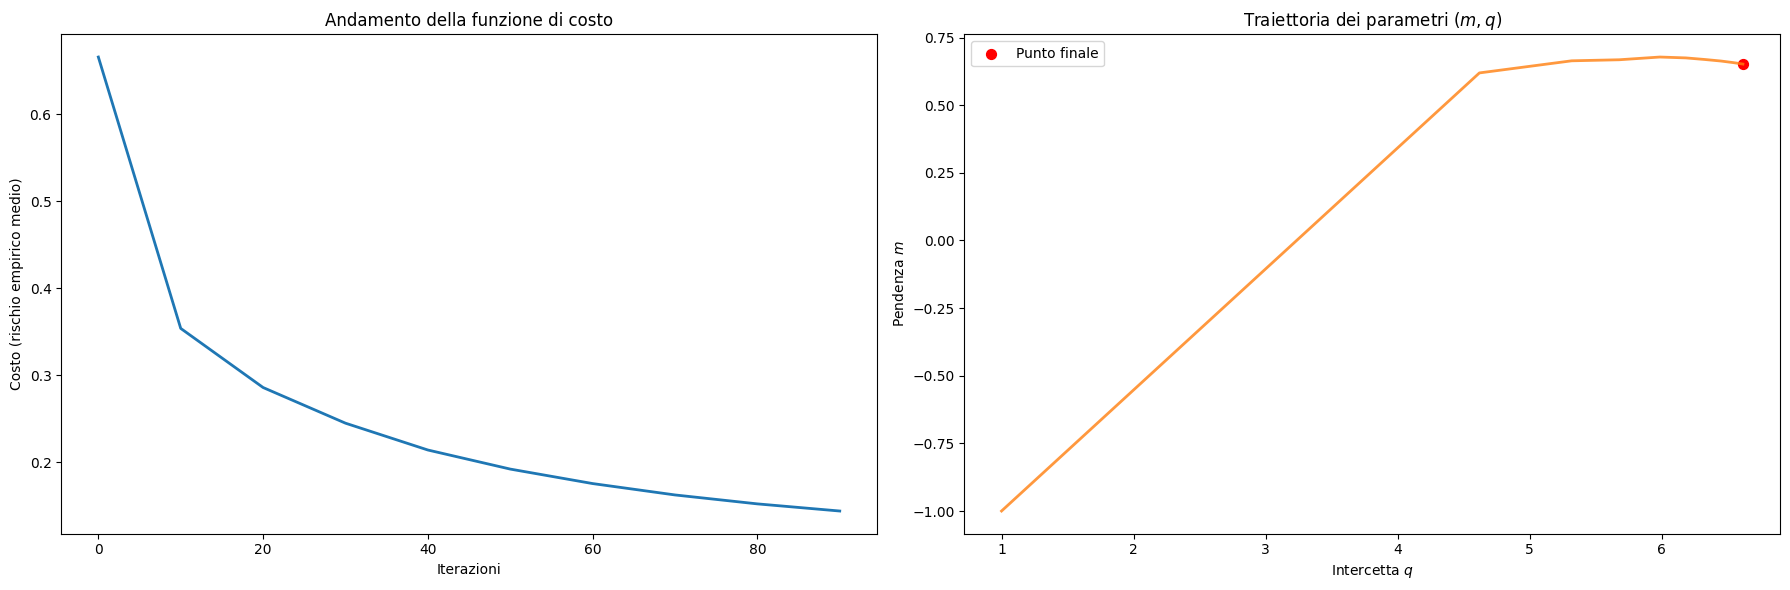

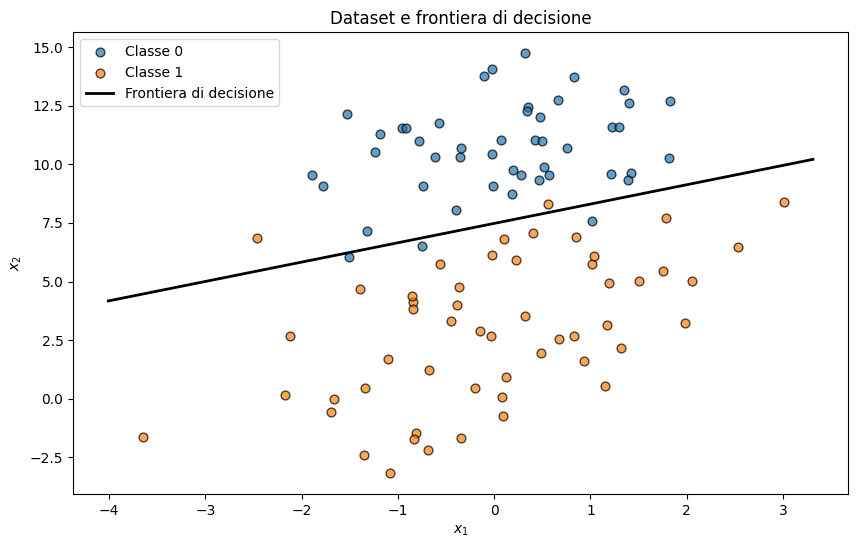

In [ ]:
# ===========================================================
# Esecuzione: RMSProp
# ===========================================================

print("Avvio ottimizzazione con RMSProp...")

start_time = time.time()
cost_rms, m_rms, q_rms = RMSProp(X, t, eta=0.1, gamma=0.9, eps=1e-8, epochs=epochs)
elapsed_time = time.time() - start_time

# -----------------------------------------------------------
# Report sintetico
# -----------------------------------------------------------
print(f"Tempo di esecuzione: {elapsed_time:6.3f} secondi")
if m_rms is not None:
    print(f"Numero di passi totali: {len(m_rms)}")
    print(f"Gradienti calcolati: {len(m_rms) * n}")
else:
    print(f"Iterazioni totali: {len(cost_rms)}")

# -----------------------------------------------------------
# Visualizzazione dei risultati
# -----------------------------------------------------------
low, high, step = 0, len(cost_rms), 10
plot_all(cost_rms, m_rms, q_rms, low, high, step)

near_opt(m_rms, min_dist=1e-1, ge_per_step=n)

plot_ds(data, m_rms[-1], q_rms[-1])

### ⚙️ Adadelta — Apprendimento adattivo senza learning rate fisso

**Adadelta** è un’evoluzione di **RMSProp** progettata per rendere l’ottimizzazione ancora più automatica e stabile.  
Nasce con due obiettivi principali:
1. Evitare di dover scegliere manualmente un learning rate $\eta$.
2. Impedire che il passo di aggiornamento si riduca troppo nel tempo, come accade in Adagrad e, in parte, in RMSProp.

In sostanza, Adadelta impara **da solo** quanto “forte” deve essere ogni passo,  
usando esclusivamente informazioni già presenti nei gradienti e negli aggiornamenti precedenti.

---

#### 🔹 Dalla logica di RMSProp all’idea di Adadelta

RMSProp correggeva il limite di Adagrad introducendo una **media mobile dei gradienti recenti**,  
così da evitare che il learning rate diminuisse all’infinito.  
Tuttavia, RMSProp **mantiene ancora un $\eta$ fisso**, scelto a mano,  
e non tiene conto di quanto i parametri si siano mossi realmente.

Adadelta risolve entrambe le questioni:
- **elimina il learning rate globale $\eta$**,  
- e introduce una seconda “memoria” che misura **quanto grandi sono stati gli aggiornamenti effettivi** dei parametri.

Così, il metodo confronta:
- la *forza* con cui il modello vuole cambiare (i gradienti),  
- con *quanto si è già mosso in passato* (gli aggiornamenti).

👉 Se i gradienti sono forti, Adadelta riduce il passo;  
se sono deboli, lo aumenta.  

Tutto accade automaticamente, senza parametri da regolare.

---

#### 🔹 Come funziona (passo dopo passo)

Ad ogni iterazione $k$, per ciascun parametro $\theta_j$:

---

#### **1️⃣ Calcolo del gradiente corrente**
> 👉 “Quanto spinge la funzione di costo in questo punto?”

$$
g_{j,k} = \frac{\partial \mathscr{R}(\theta)}{\partial \theta_j}\Big|_{\theta = \theta^{(k)}}.
$$

Questo è il punto di partenza: il gradiente indica **la direzione** in cui la funzione cresce più rapidamente.  Noi ci muoveremo nella direzione opposta per minimizzarla.

---

#### **2️⃣ Media mobile dei quadrati dei gradienti**
> 👉 “Quanta forza media hanno avuto i gradienti di recente?”

$$
\tilde{G}_{j,k} = \gamma \, \tilde{G}_{j,k-1} + (1 - \gamma)\, g_{j,k}^2.
$$

Questo passaggio costruisce una **memoria esponenziale** dei gradienti.  
Serve per capire *la scala tipica* dei loro valori: se i gradienti sono grandi, il terreno è ripido; se sono piccoli, il terreno è quasi piatto.

---

#### **3️⃣ Calcolo dell’aggiornamento normalizzato**
> 👉 “Quanto devo muovermi adesso, rispetto al passato?”

$$
\Delta_{j,k} = - \frac{\sqrt{\overline{G}_{j,k-1} + \varepsilon}}
{\sqrt{\tilde{G}_{j,k} + \varepsilon}} \, g_{j,k}.
$$

Qui Adadelta fa qualcosa di **intelligente**:  non si limita a scalare il gradiente, ma **confronta** due quantità:
- **Numeratore:** quanto ci siamo mossi in passato ($\overline{G}_{j,k-1}$);  
- **Denominatore:** quanto è forte il gradiente ora ($\tilde{G}_{j,k}$).

Il rapporto bilancia il passo: se i gradienti sono molto grandi, il denominatore aumenta → passo più piccolo; se sono deboli, il passo si allunga.

> 💡 All’inizio $\overline{G}_{j,0}=0$, quindi il primo passo è piccolo ma non nullo, grazie a $\varepsilon$.

---

#### **4️⃣ Aggiornamento della memoria dei passi**
> 👉 “Aggiorna il ricordo di quanto ti sei mosso.”

$$
\overline{G}_{j,k} = \gamma \, \overline{G}_{j,k-1} + (1 - \gamma)\, \Delta_{j,k}^2
$$

Ora Adadelta aggiorna la sua **seconda memoria**, che tiene conto della *dimensione effettiva* dei passi già fatti. Questa informazione servirà nel prossimo ciclo (al punto 3) per regolare di nuovo la scala del passo.

#### **5️⃣ Aggiornamento del parametro**
> 👉 “Applica il passo appena calcolato.”

$$
\theta_j^{(k+1)} = \theta_j^{(k)} + \Delta_{j,k}
$$

Il parametro si sposta secondo il passo autoregolato.  
Niente learning rate da scegliere: l’ampiezza del movimento è già calibrata dai punti precedenti.

---

#### 🔹 Il ruolo del parametro $\gamma$

Il parametro $\gamma$ (o $\rho$) decide **quanta memoria** tenere del passato:

- **$\gamma$ alto (0.95–0.99)** → memoria lunga → aggiornamenti stabili ma lenti.  
- **$\gamma$ basso (0.8–0.9)** → memoria corta → aggiornamenti rapidi ma più rumorosi.

👉 In pratica, $\gamma$ regola la “memoria temporale” del metodo.  
Valori attorno a **0.9–0.95** sono un buon compromesso.

---

#### 💡 In sintesi

| Concetto | Significato |
|-----------|-------------|
| $\tilde{G}_{j,k}$ | Media mobile dei quadrati dei gradienti |
| $\overline{G}_{j,k}$ | Media mobile dei quadrati degli aggiornamenti |
| $\gamma$ | Fattore di smorzamento (controlla la memoria) |
| $\varepsilon$ | Termine di stabilizzazione numerica |
| ✅ Vantaggio | Nessun learning rate fisso; passo che si autoregola |
| ⚙️ Effetto | Aggiornamenti stabili e consistenti nel tempo |

---

In breve, **Adadelta** è un *RMSProp autobilanciato*:  usa la memoria sia dei gradienti che dei passi per regolare automaticamente la scala degli aggiornamenti,  rendendo l’apprendimento **stabile, robusto e completamente automatico**,  senza mai scegliere manualmente il valore di $\eta$.

In [ ]:
def Adadelta(X, t, gamma=0.9, eps=1e-8, epochs=10000):
    """
    Implementazione dell'ottimizzatore Adadelta.

    Adadelta è una variante di Adagrad e RMSProp che elimina la necessità
    di scegliere esplicitamente il learning rate (eta). Invece, adatta la scala
    degli aggiornamenti in base al rapporto tra le varianze dei gradienti e
    degli aggiornamenti passati.

    Parametri
    ----------
    X : ndarray di forma (n, d+1)
        Matrice delle feature (inclusa la colonna di bias).
    t : ndarray di forma (n, 1)
        Vettore dei target binari {0,1}.
    gamma : float, default=0.9
        Fattore di decadimento esponenziale per le medie mobili.
    eps : float, default=1e-8
        Piccola costante per stabilità numerica.
    epochs : int, default=10000
        Numero di iterazioni dell'algoritmo.

    Ritorna
    -------
    cost_history : ndarray
        Valori della funzione di costo per ogni epoca.
    m, q : ndarray
        Coefficienti della retta di separazione (solo per caso 2D).
    """

    n_features = X.shape[1]
    theta = np.zeros((n_features, 1))
    G_tilde = np.zeros_like(theta)  # media mobile dei gradienti al quadrato
    G_over = np.zeros_like(theta)   # media mobile degli aggiornamenti al quadrato
    theta_history = []
    cost_history = []

    for epoch in range(epochs):
        g = gradient(theta, X, t)

        # Aggiornamento della media mobile dei gradienti al quadrato
        G_tilde = gamma * G_tilde + (1 - gamma) * g**2

        # Calcolo dell'aggiornamento normalizzato
        delta = - np.sqrt(G_over + eps) / np.sqrt(G_tilde + eps) * g

        # Aggiornamento della media mobile degli incrementi al quadrato
        G_over = gamma * G_over + (1 - gamma) * delta**2

        # Aggiornamento dei parametri
        theta = theta + delta

        theta_history.append(theta.copy())
        cost_history.append(cost(theta, X, t))

    # Conversione in array
    theta_history = np.array(theta_history).reshape(-1, n_features)
    cost_history = np.array(cost_history).reshape(-1, 1)

    # Calcolo m e q per visualizzazione (caso 2D)
    if n_features == 3:
        m = -theta_history[:, 1] / theta_history[:, 2]
        q = -theta_history[:, 0] / theta_history[:, 2]
    else:
        m, q = None, None

    return cost_history, m, q

Avvio ottimizzazione con Adadelta...
Tempo di esecuzione:  0.017 secondi
Numero di passi totali: 100
Gradienti calcolati: 10000


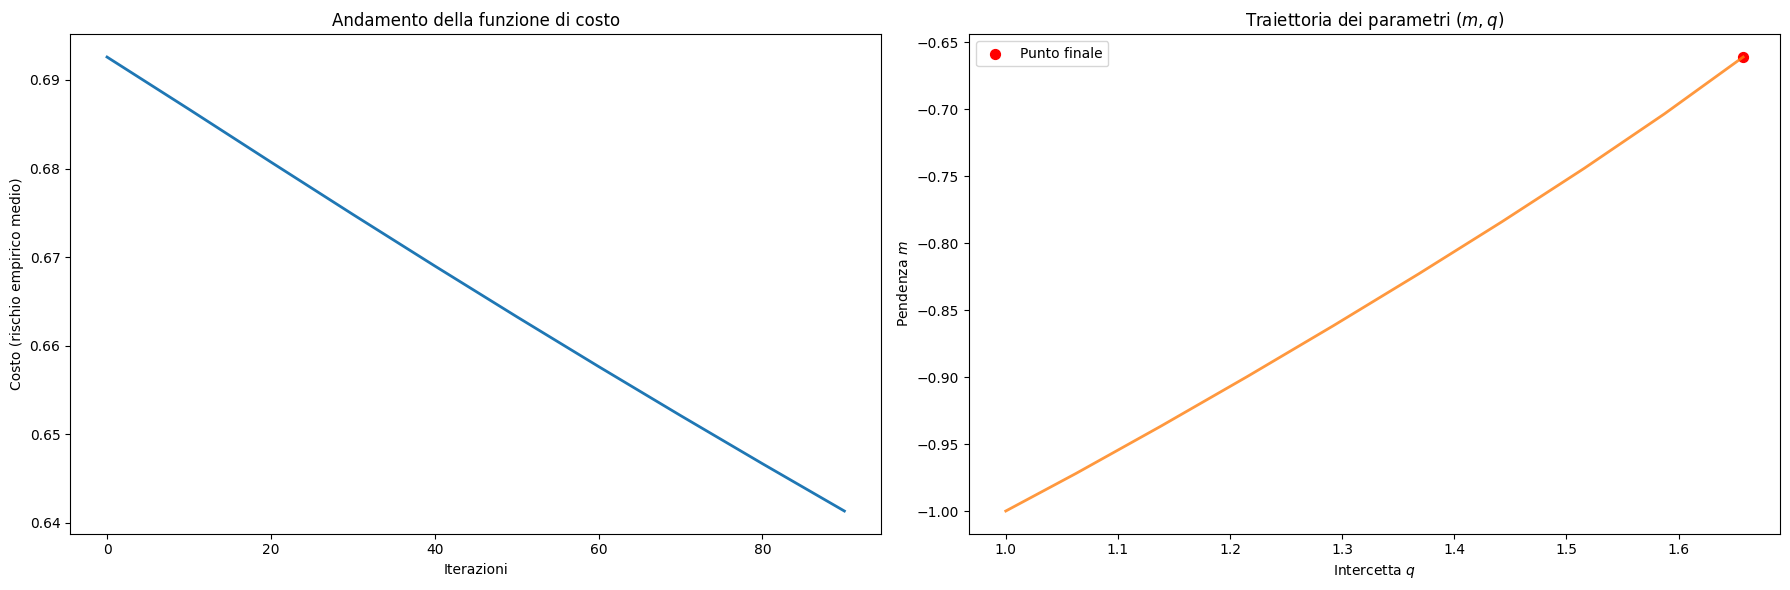

Convergenza raggiunta al passo 1 (100 gradienti calcolati)


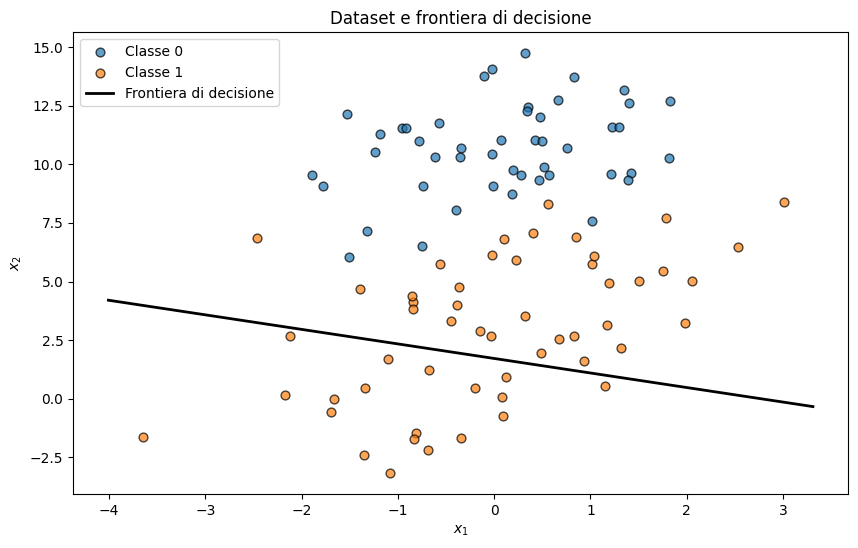

In [ ]:
# ===========================================================
# Esecuzione: Adadelta
# ===========================================================

print("Avvio ottimizzazione con Adadelta...")

start_time = time.time()
cost_ada_d, m_ada_d, q_ada_d = Adadelta(X, t, gamma=0.9, eps=1e-9, epochs=epochs)
elapsed_time = time.time() - start_time

# -----------------------------------------------------------
# Report sintetico
# -----------------------------------------------------------
print(f"Tempo di esecuzione: {elapsed_time:6.3f} secondi")
if m_ada_d is not None:
    print(f"Numero di passi totali: {len(m_ada_d)}")
    print(f"Gradienti calcolati: {len(m_ada_d) * n}")
else:
    print(f"Iterazioni totali: {len(cost_ada_d)}")

# -----------------------------------------------------------
# Visualizzazione dei risultati
# -----------------------------------------------------------
low, high, step = 0, len(cost_ada_d), 10
plot_all(cost_ada_d, m_ada_d, q_ada_d, low, high, step)

near_opt(m_ada_d, min_dist=1e-1, ge_per_step=n)

plot_ds(data, m_ada_d[-1], q_ada_d[-1])

### ⚙️ Adam — Adaptive Moment Estimation

**Adam** (*Adaptive Moment Estimation*) è uno degli ottimizzatori più usati nel Machine Learning e nel Deep Learning.  
Unisce le idee di **Momentum** e **RMSProp**, aggiungendo una correzione iniziale per evitare stime distorte dei gradienti.

---

#### 🔹 L’idea di fondo

Adam tiene in memoria due informazioni sui gradienti:

1. una **media mobile dei gradienti** → serve a capire **la direzione media** del cambiamento (come il *momentum*);  
2. una **media mobile dei quadrati dei gradienti** → serve a capire **quanto forti** sono i gradienti (come *RMSProp*).

In breve:
- la prima aiuta a rendere il movimento più **fluido e costante**,  
- la seconda regola **automaticamente la scala del passo**.

---

#### 🔹 Le due medie mobili

Ad ogni passo $k$, per ogni parametro $\theta_j$:

$$
\begin{aligned}
\tilde{m}_{j,k} &= \beta_1 \, \tilde{m}_{j,k-1} + (1 - \beta_1)\, g_{j,k} \\
\tilde{v}_{j,k} &= \beta_2 \, \tilde{v}_{j,k-1} + (1 - \beta_2)\, g_{j,k}^2
\end{aligned}
$$

dove:
- $g_{j,k}$ è il gradiente corrente,  
- $\beta_1$ (≈ 0.9) decide **quanta memoria dare alla direzione media**,  
- $\beta_2$ (≈ 0.999) decide **quanta memoria dare alla forza dei gradienti**.

---

#### 🔹 Correzione del bias iniziale

All’inizio, le medie $\tilde{m}$ e $\tilde{v}$ partono da zero, quindi risultano troppo piccole.  
Adam corregge questo “bias” con un fattore che dipende dal numero di iterazioni:

$$
\hat{m}_{j,k} = \frac{\tilde{m}_{j,k}}{1 - \beta_1^k}, \quad
\hat{v}_{j,k} = \frac{\tilde{v}_{j,k}}{1 - \beta_2^k}.
$$

Dopo questa correzione, le due grandezze riflettono in modo più realistico l’andamento dei gradienti.

---

#### 🔹 Aggiornamento del parametro

Infine, Adam aggiorna ogni parametro con:

$$
\theta_j^{(k+1)} = \theta_j^{(k)} - \frac{\eta}{\sqrt{\hat{v}_{j,k} + \varepsilon}} \, \hat{m}_{j,k}
$$

dove:
- $\eta$ è il learning rate di base (es. 0.001),  
- $\varepsilon$ è un piccolo valore per evitare divisioni per zero.

👉 $\hat{m}$ indica **la direzione media di discesa**,  
mentre $\sqrt{\hat{v}}$ regola **la grandezza del passo** in modo adattivo.

---

#### 🔹 Come si comporta

- Se i gradienti sono **coerenti nel tempo**, $\hat{m}$ si accumula → il passo accelera.  
- Se i gradienti sono **molto variabili**, $\hat{v}$ cresce → il passo si riduce per stabilizzare.  

Così Adam combina la **velocità del Momentum** e la **stabilità di RMSProp**, adattandosi automaticamente.

---

#### 💡 In sintesi

| Concetto | Significato |
|-----------|-------------|
| $\tilde{m}$ | Media mobile dei gradienti (direzione media) |
| $\tilde{v}$ | Media mobile dei quadrati dei gradienti (intensità media) |
| $\beta_1, \beta_2$ | Controllano la memoria dei due momenti |
| $\hat{m}, \hat{v}$ | Versioni corrette dal bias |
| $\eta$ | Learning rate di base |
| ✅ Vantaggio | Rapido, stabile e adattivo |
| ⚠️ Limite | Troppa inerzia se i gradienti cambiano spesso direzione |

---

In breve, **Adam** funziona come un *pilota automatico intelligente*: ricorda la direzione media dei gradienti, valuta la loro intensità, e regola da solo la velocità di apprendimento per ottenere una **convergenza rapida e stabile**.

In [ ]:
def Adam(X, t, eta=0.001, beta1=0.9, beta2=0.999, eps=1e-8, epochs=10000):
    """
    Implementazione dell'ottimizzatore Adam (Adaptive Moment Estimation).

    Adam combina:
      - il metodo del momento (media mobile dei gradienti, 1° momento)
      - RMSProp (media mobile dei quadrati dei gradienti, 2° momento)
    con correzione del bias per le stime dei momenti.

    Parametri
    ----------
    X : ndarray di forma (n, d+1)
        Matrice delle feature (inclusa la colonna di bias).
    t : ndarray di forma (n, 1)
        Vettore dei target binari {0,1}.
    eta : float, default=0.001
        Learning rate.
    beta1 : float, default=0.9
        Fattore di decadimento per la media mobile del gradiente (1° momento).
    beta2 : float, default=0.999
        Fattore di decadimento per la media mobile del quadrato del gradiente (2° momento).
    eps : float, default=1e-8
        Piccola costante per la stabilità numerica.
    epochs : int, default=10000
        Numero di iterazioni dell'algoritmo.

    Ritorna
    -------
    cost_history : ndarray
        Valori della funzione di costo per ogni epoca.
    m, q : ndarray
        Coefficienti della retta di separazione (solo per caso 2D).
    """

    n_features = X.shape[1]
    theta = np.zeros((n_features, 1))

    # Inizializzazione dei momenti
    m_tilde = np.zeros_like(theta)  # Primo momento (gradiente)
    v_tilde = np.zeros_like(theta)  # Secondo momento (gradiente al quadrato)

    theta_history = []
    cost_history = []

    for epoch in range(epochs):
        g = gradient(theta, X, t)

        # Aggiornamento dei momenti esponenziali
        m_tilde = beta1 * m_tilde + (1 - beta1) * g
        v_tilde = beta2 * v_tilde + (1 - beta2) * (g ** 2)

        # Correzione del bias (fondamentale nelle prime iterazioni)
        m_hat = m_tilde / (1 - beta1 ** (epoch + 1))
        v_hat = v_tilde / (1 - beta2 ** (epoch + 1))

        # Aggiornamento dei parametri
        theta -= eta * m_hat / (np.sqrt(v_hat) + eps)

        theta_history.append(theta.copy())
        cost_history.append(cost(theta, X, t))

    # Conversione in array
    theta_history = np.array(theta_history).reshape(-1, n_features)
    cost_history = np.array(cost_history).reshape(-1, 1)

    # Calcolo m e q per il caso bidimensionale
    if n_features == 3:
        m = -theta_history[:, 1] / theta_history[:, 2]
        q = -theta_history[:, 0] / theta_history[:, 2]
    else:
        m, q = None, None

    return cost_history, m, q

Avvio ottimizzazione con Adam...
Tempo di esecuzione:  0.027 secondi
Numero di passi totali: 100
Gradienti calcolati: 10000


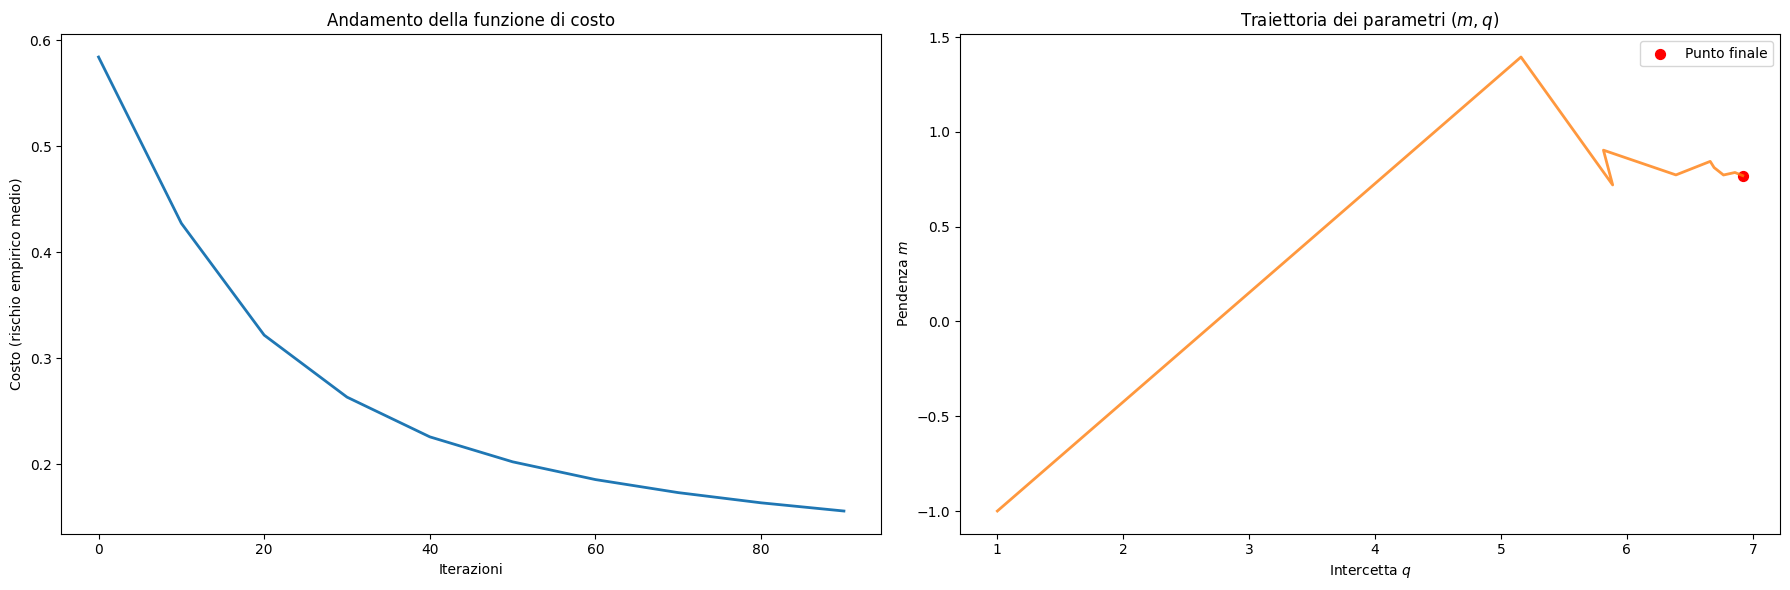

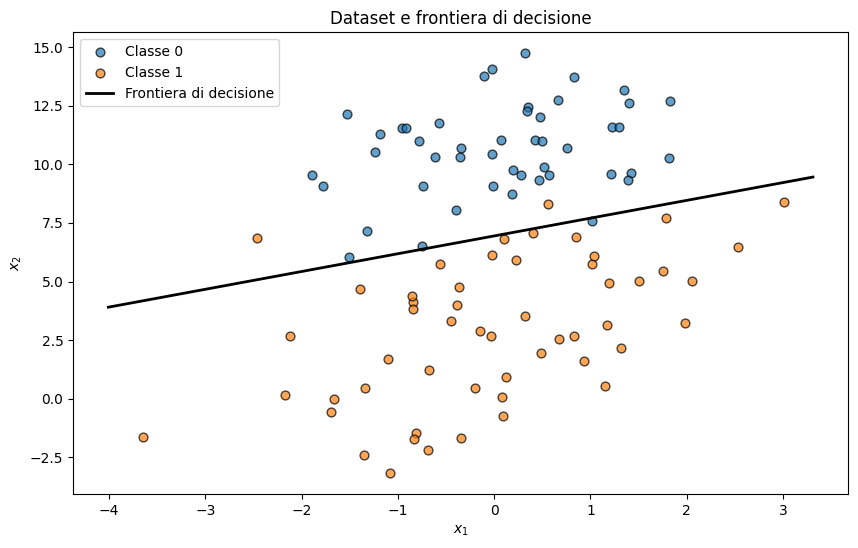

In [ ]:
# ===========================================================
# Esecuzione: Adam
# ===========================================================

print("Avvio ottimizzazione con Adam...")

start_time = time.time()
cost_adam, m_adam, q_adam = Adam(X, t, eta=0.1, beta1=0.9, beta2=0.999, eps=1e-8, epochs=epochs)
elapsed_time = time.time() - start_time

# -----------------------------------------------------------
# Report sintetico
# -----------------------------------------------------------
print(f"Tempo di esecuzione: {elapsed_time:6.3f} secondi")
if m_adam is not None:
    print(f"Numero di passi totali: {len(m_adam)}")
    print(f"Gradienti calcolati: {len(m_adam) * n}")
else:
    print(f"Iterazioni totali: {len(cost_adam)}")

# -----------------------------------------------------------
# Visualizzazione dei risultati
# -----------------------------------------------------------
low, high, step = 0, len(cost_adam), 10
plot_all(cost_adam, m_adam, q_adam, low, high, step)

plot_ds(data, m_adam[-1], q_adam[-1])

### Metodi del secondo ordine

### ⚙️ Metodo di Newton-Raphson per l’Ottimizzazione

La ricerca di un **punto di massimo o minimo** di una funzione può essere vista come la ricerca dei punti in cui la **derivata prima** (o, in generale, il **gradiente**) si annulla.

In altre parole, se vogliamo trovare un punto stazionario $x^*$ tale che $f'(x^*) = 0$,  
possiamo applicare un metodo iterativo di **ricerca degli zeri** della derivata.

---

#### 🔹 Il metodo di Newton-Raphson (caso univariato)

Nel caso di una funzione univariata $f(x)$, il **metodo di Newton-Raphson** aggiorna la stima del punto di radice nel modo seguente:

$$
x_{i+1} = x_i - \frac{f(x_i)}{f'(x_i)}
$$

Ad ogni passo:
- si costruisce la **retta tangente** a $f$ nel punto $(x_i, f(x_i))$,
- si trova la sua **intersezione con l’asse $x$**, ottenendo la nuova stima $x_{i+1}$.

L’idea è che la tangente rappresenti un’approssimazione locale della funzione,  
e il suo punto di intersezione con l’asse $x$ fornisca un miglioramento dell’approssimazione della radice.

![Newton-Raphson.](https://tvml.github.io/ml2425/codici/assets/newton.png)

---

#### 🔹 Ricerca di massimi o minimi

Quando l’obiettivo non è trovare lo zero di $f(x)$, ma piuttosto un punto di **massimo o minimo**,
si applica lo stesso principio alla derivata della funzione.

Si impone quindi la condizione $f'(x) = 0$ e si applica Newton-Raphson a questa equazione:

$$
x_{i+1} = x_i - \frac{f'(x_i)}{f''(x_i)}
$$

In questo caso:
- $f'(x_i)$ indica la **pendenza** della funzione nel punto corrente,
- $f''(x_i)$ (la derivata seconda) fornisce l’informazione sulla **curvatura locale**,  
  e consente di adattare dinamicamente l’ampiezza del passo.

---

#### 🔹 Estensione multivariata

Per funzioni multivariate $f(\mathbf{x})$,  
la derivata prima viene sostituita dal **gradiente** $\nabla f$,  
e la derivata seconda diventa la **matrice Hessiana** $H(f)$, definita come:

$$
H_{ij}(f) = \frac{\partial^2 f}{\partial x_i \partial x_j}
$$

L’aggiornamento iterativo assume quindi la forma vettoriale:

$$
\mathbf{x}^{(i+1)} = \mathbf{x}^{(i)} - \big( H(f)^{-1} \nabla f \big) \Big|_{\mathbf{x}^{(i)}}
$$

---

#### 🔹 Interpretazione

- Il termine $\nabla f$ indica la **direzione di massima pendenza** (come nella discesa del gradiente).  
- L’inverso dell’Hessiana $H^{-1}$ **adatta la scala del passo** in base alla curvatura locale della funzione.  
- Se la funzione è **convessa** e l’Hessiana è definita positiva, l’algoritmo converge rapidamente verso il minimo locale.

---

#### 💡 In sintesi

| Quantità | Significato | Ruolo |
|-----------|--------------|-------|
| $\nabla f$ | Gradiente | Direzione di discesa locale |
| $H(f)$ | Hessiana | Curvatura della funzione |
| $H^{-1}\nabla f$ | Correzione del passo | Adattamento alla geometria locale |
| $x_{i+1} = x_i - \frac{f'(x_i)}{f''(x_i)}$ | Versione scalare | Newton-Raphson classico |
| $\mathbf{x}^{(i+1)} = \mathbf{x}^{(i)} - H^{-1}\nabla f$ | Versione vettoriale | Estensione multivariata |

---

Il metodo di Newton-Raphson fornisce una **convergenza quadratica** in prossimità del minimo,  
ma richiede il calcolo (e l’inversione) della matrice Hessiana — un’operazione costosa per funzioni con molti parametri, come nei modelli di Machine Learning.

In [ ]:
def sigma(theta, X):
    """Funzione sigmoide: restituisce la probabilità stimata."""
    z = np.dot(X, theta)
    return 1 / (1 + np.exp(-z))


def gradient(theta, X, t):
    """Gradiente del rischio empirico per regressione logistica."""
    return -np.dot(X.T, (t - sigma(theta, X))) / len(X)


def hessian(theta, X):
    """
    Calcola la matrice hessiana della funzione di costo logistica.
    H = (1/n) * Σ_i [ σ_i (1 - σ_i) x_i x_iᵀ ]
    """
    p = sigma(theta, X)
    n = X.shape[0]
    H = np.zeros((X.shape[1], X.shape[1]))
    for i in range(n):
        x_i = X[i, :].reshape(-1, 1)
        H += p[i] * (1 - p[i]) * np.dot(x_i, x_i.T)
    return H / n


def newton(X, t, epochs=100):
    """
    Metodo di Newton-Raphson per la regressione logistica.

    Utilizza il secondo ordine (Hessiana) per aggiornare i parametri.
    Converge più rapidamente dei metodi di discesa del gradiente,
    ma richiede il calcolo e l’inversione dell’Hessiana a ogni passo.

    Parametri
    ----------
    X : ndarray di forma (n, d+1)
        Matrice delle feature (inclusa la colonna di bias).
    t : ndarray di forma (n, 1)
        Vettore dei target binari {0,1}.
    epochs : int, default=100
        Numero massimo di iterazioni.

    Ritorna
    -------
    cost_history : ndarray
        Andamento della funzione di costo.
    m, q : ndarray
        Parametri per la visualizzazione (caso 2D).
    """

    n_features = X.shape[1]
    theta = np.zeros((n_features, 1))
    theta_history = []
    cost_history = []

    for k in range(epochs):
        g = gradient(theta, X, t)
        H = hessian(theta, X)

        # Aggiungo un termine di regolarizzazione per stabilità numerica
        try:
            H_inv = np.linalg.inv(H + 1e-6 * np.eye(H.shape[0]))
        except np.linalg.LinAlgError:
            print(f"Hessiana non invertibile al passo {k}.")
            break

        theta -= np.dot(H_inv, g)

        theta_history.append(theta.copy())
        cost_history.append(cost(theta, X, t))

        # criterio di arresto opzionale
        if np.linalg.norm(g) < 1e-6:
            print(f"Convergenza raggiunta al passo {k}.")
            break

    theta_history = np.array(theta_history).reshape(-1, n_features)
    cost_history = np.array(cost_history).reshape(-1, 1)

    # Solo per il caso 2D (bias + 2 feature)
    if n_features == 3:
        m = -theta_history[:, 1] / theta_history[:, 2]
        q = -theta_history[:, 0] / theta_history[:, 2]
    else:
        m, q = None, None

    return cost_history, m, q

Avvio ottimizzazione con Newton-Raphson...
Convergenza raggiunta al passo 8.
Tempo di esecuzione:  0.017 secondi
Numero di passi totali: 9
Gradienti calcolati: 900


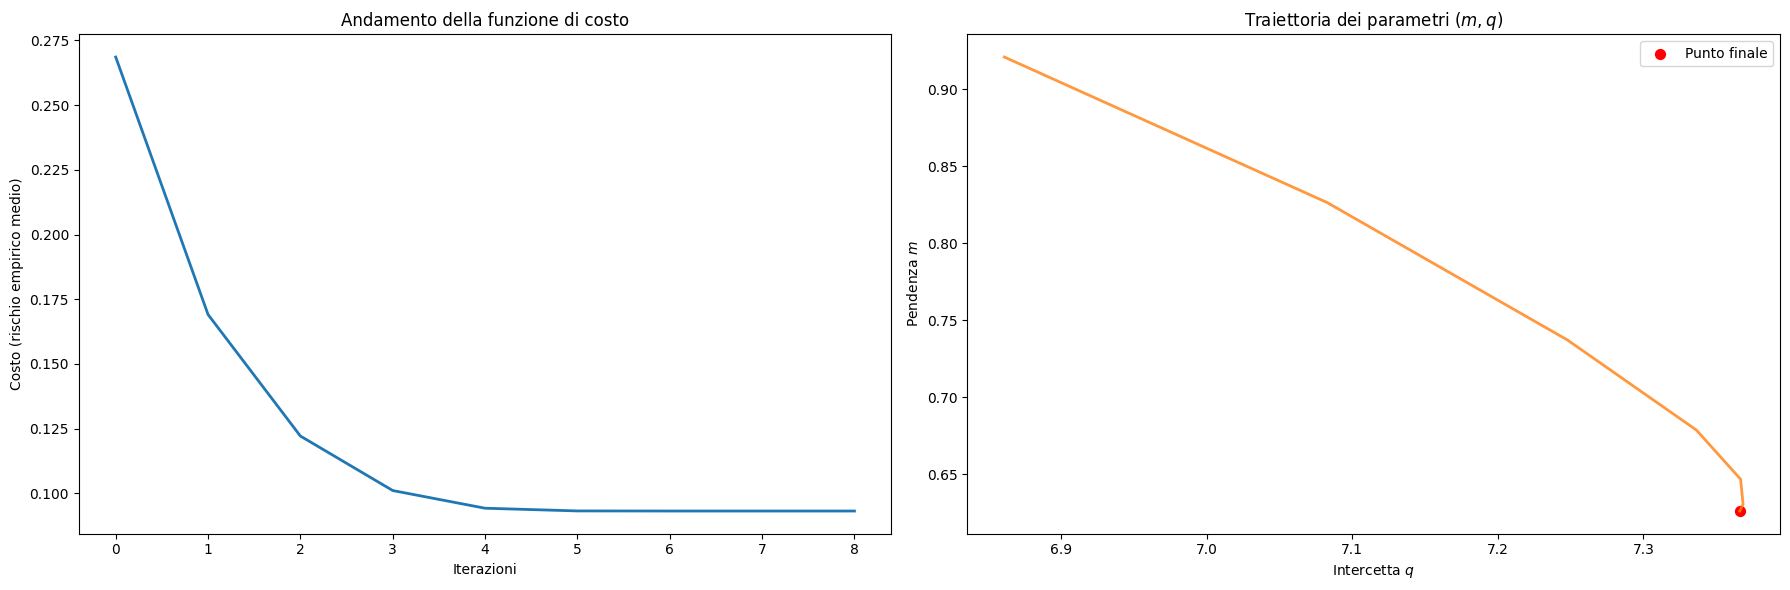

Convergenza raggiunta al passo 7 (700 gradienti calcolati)


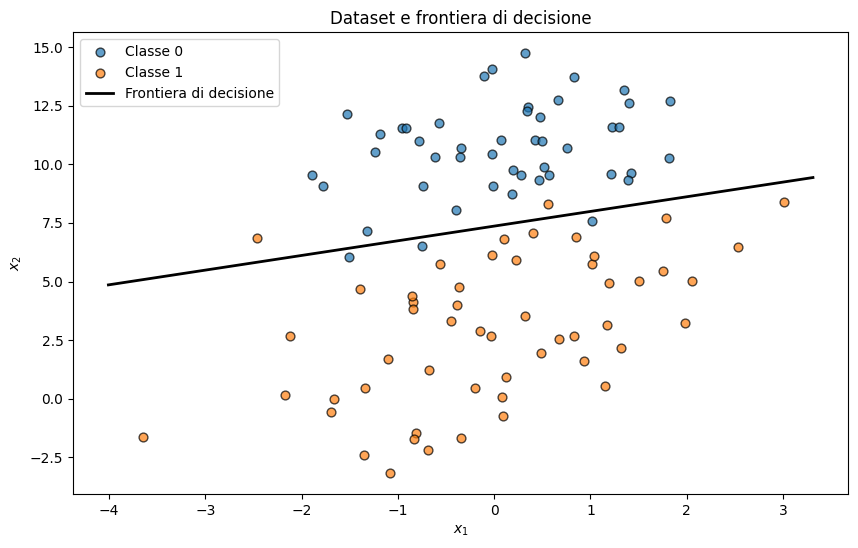

In [ ]:
# ===========================================================
# Esecuzione: Metodo di Newton-Raphson
# ===========================================================

print("Avvio ottimizzazione con Newton-Raphson...")

start_time = time.time()
cost_newton, m_newton, q_newton = newton(X, t, epochs=epochs)
elapsed_time = time.time() - start_time

# -----------------------------------------------------------
# Report sintetico
# -----------------------------------------------------------
print(f"Tempo di esecuzione: {elapsed_time:6.3f} secondi")
if m_newton is not None:
    print(f"Numero di passi totali: {len(m_newton)}")
    print(f"Gradienti calcolati: {len(m_newton) * n}")
else:
    print(f"Iterazioni totali: {len(cost_newton)}")

# -----------------------------------------------------------
# Visualizzazione dei risultati
# -----------------------------------------------------------
low, high, step = 0, len(cost_newton), 1
plot_all(cost_newton, m_newton, q_newton, low, high, step)

near_opt(m_newton, min_dist=1e-3, ge_per_step=n)

plot_ds(data, m_newton[-1], q_newton[-1])

## 📊 Valutazione delle prestazioni dei metodi di ottimizzazione

Abbiamo implementato diversi **ottimizzatori avanzati** — come Momentum, Nesterov, Adagrad, RMSProp, Adadelta, Adam e Newton-Raphson — e osservato il loro comportamento in termini di convergenza e stabilità.  
Ora vogliamo rispondere alla domanda fondamentale: **quanto bene predicono?**

Per valutarlo, misuriamo l’**accuratezza finale di classificazione** dei modelli ottenuti da ciascun metodo, utilizzando i parametri finali $\theta$ per predire le etichette del dataset e confrontarle con i valori reali.

⚠️ **Attenzione:** in questa fase stiamo **valutando le prestazioni sullo stesso dataset usato per l’addestramento**.  
Questo significa che i risultati potrebbero essere **ottimistici**, perché non misurano la capacità del modello di generalizzare su dati nuovi.  

In un contesto reale, per una valutazione corretta dovremmo usare:
- un **validation set** (insieme di dati separato), oppure  
- una **cross-validation** per stimare le prestazioni su dati non visti.

In questo laboratorio, tuttavia, l’obiettivo è **confrontare gli ottimizzatori tra loro**, verificando quanto rapidamente e accuratamente riescono a minimizzare il rischio empirico sul dataset di training.

In [ ]:
# ===============================================================
# 🔎 Valutazione finale delle prestazioni dei diversi ottimizzatori
# ===============================================================
# Convenzione: θ₂ < 0 (cioè il coefficiente di x₂ è negativo)
# così che la retta di separazione x₂ = m x₁ + q sia coerente
# con le definizioni usate durante l'addestramento.
# ===============================================================

def mq_from_theta(theta):
    """
    Estrae (m, q) dai parametri θ di una regressione logistica 2D.
    θ = [θ₀, θ₁, θ₂]^T → x₂ = -θ₁/θ₂ · x₁ - θ₀/θ₂
    """
    th = theta.reshape(-1, 1).astype(float)
    m = -th[1, 0] / th[2, 0]
    q = -th[0, 0] / th[2, 0]
    return m, q


def theta_from_mq(m, q):
    """
    Ricostruisce θ coerente con la frontiera x₂ = m x₁ + q:
    θ₀ = q, θ₁ = m, θ₂ = -1.
    """
    return np.array([q, m, -1.0]).reshape(-1, 1)


def predict(theta, X, thr=0.5):
    """Predice la classe (0/1) per ciascun campione, dati θ."""
    probs = f(theta, X)
    return (probs >= thr).astype(int)


# ===============================================================
# 📊 Confronto finale delle accuratezze
# ===============================================================

print("\n=== 📊 ACCURATEZZA FINALE DEI MODELLI ===")
print(f"{'Metodo':<20}{'Accuratezza':<12}")

# Momentum
theta_final_mom = theta_from_mq(m_mom[-1], q_mom[-1])
acc_mom = (predict(theta_final_mom, X) == t).mean()
print(f"{'Momentum':<20}{acc_mom:<12.3f}")

# Nesterov
theta_final_nag = theta_from_mq(m_nag[-1], q_nag[-1])
acc_nag = (predict(theta_final_nag, X) == t).mean()
print(f"{'Nesterov':<20}{acc_nag:<12.3f}")

# Adagrad
theta_final_ada = theta_from_mq(m_ada[-1], q_ada[-1])
acc_ada = (predict(theta_final_ada, X) == t).mean()
print(f"{'Adagrad':<20}{acc_ada:<12.3f}")

# RMSProp
theta_final_rms = theta_from_mq(m_rms[-1], q_rms[-1])
acc_rms = (predict(theta_final_rms, X) == t).mean()
print(f"{'RMSProp':<20}{acc_rms:<12.3f}")

# Adadelta
theta_final_add = theta_from_mq(m_ada_d[-1], q_ada_d[-1])
acc_add = (predict(theta_final_add, X) == t).mean()
print(f"{'Adadelta':<20}{acc_add:<12.3f}")

# Adam
theta_final_adam = theta_from_mq(m_adam[-1], q_adam[-1])
acc_adam = (predict(theta_final_adam, X) == t).mean()
print(f"{'Adam':<20}{acc_adam:<12.3f}")

# Newton-Raphson
theta_final_newton = theta_from_mq(m_newton[-1], q_newton[-1])
acc_newton = (predict(theta_final_newton, X) == t).mean()
print(f"{'Newton-Raphson':<20}{acc_newton:<12.3f}")


=== 📊 ACCURATEZZA FINALE DEI MODELLI ===
Metodo              Accuratezza 
Momentum            0.950       
Nesterov            0.950       
Adagrad             0.890       
RMSProp             0.950       
Adadelta            0.660       
Adam                0.970       
Newton-Raphson      0.950       


# 📘 Riepilogo — Metodi di Ottimizzazione Avanzata

In questo laboratorio abbiamo confrontato diverse varianti del **gradient descent**,  
ognuna progettata per migliorare la **velocità**, la **stabilità** o la **robustezza** della convergenza.

| **Algoritmo** | **Idea chiave** | **Parametri principali** | **Vantaggi** | **Limiti** |
|----------------|-----------------|---------------------------|---------------|-------------|
| **Momentum** | Aggiunge una *velocità* che tiene conto dei gradienti passati → effetto di inerzia. | `η` (learning rate), `γ` (fattore di momento) | Convergenza più fluida e veloce; riduce oscillazioni. | Può oscillare se γ è troppo alto. |
| **Nesterov Accelerated Gradient (NAG)** | Calcola il gradiente *“in anticipo”* nel punto predetto (*look-ahead*). | `η`, `γ` | Anticipa la direzione corretta, riducendo overshooting. | Richiede due valutazioni del gradiente per interpretazione. |
| **Adagrad** | Learning rate adattivo per ciascun parametro, basato sulla somma cumulativa dei gradienti al quadrato. | `η`, `ε` | Adatta automaticamente il passo; ottimo per dati sparsi. | Il learning rate decresce troppo nel tempo. |
| **RMSProp** | Usa una **media mobile esponenziale** dei quadrati dei gradienti (invece della somma cumulativa). | `η`, `γ`, `ε` | Mantiene un learning rate efficace nel tempo. | Necessita scelta accurata di γ. |
| **Adadelta** | Rende il passo completamente adattivo eliminando η; confronta la scala dei gradienti con quella degli aggiornamenti passati. | `γ`, `ε` | Nessun learning rate da fissare; convergenza stabile. | Maggior complessità concettuale. |
| **Adam** | Combina Momentum + RMSProp con correzione del bias sui momenti. | `η`, `β₁`, `β₂`, `ε` | Veloce, stabile e robusto; standard de facto nel deep learning. | Può accumulare troppa inerzia. |
| **Newton-Raphson** | Usa anche la curvatura (Hessiana) → passo proporzionato all’inverso della derivata seconda. | — | Convergenza quadratica vicino al minimo. | Richiede calcolo e inversione dell’Hessiana (costoso). |

---

### 📊 Confronto qualitativo

| **Metodo** | **Memoria storica** | **Adattività del passo** | **Uso del 2° ordine** | **Velocità di convergenza** |
|-------------|---------------------|---------------------------|------------------------|------------------------------|
| Gradient Descent | ❌ | ❌ | ❌ | 🟡 Lenta |
| Momentum | ✅ | ❌ | ❌ | 🟢 Più rapida |
| Nesterov | ✅ | ❌ | ❌ | 🟢🟢 Molto rapida |
| Adagrad | ❌ | ✅ | ❌ | 🟢 all’inizio, poi 🟠 |
| RMSProp | ❌ | ✅ | ❌ | 🟢 Stabile |
| Adadelta | ✅ | ✅ | ❌ | 🟢🟢 Costante nel tempo |
| Adam | ✅✅ | ✅✅ | ❌ | 🟢🟢🟢 Ottimale |
| Newton-Raphson | ❌ | ❌ | ✅ | 🔵 Convergenza quadratica (locale) |

---

### 💬 Conclusione

- Tutti i metodi si basano sull’idea comune di **muoversi nella direzione del gradiente**, ma differiscono nel modo in cui decidono **quanto e come** compiere il passo di aggiornamento.  
- I metodi **adattivi** (Adagrad, RMSProp, Adadelta, Adam) sono oggi i più usati nei contesti di *deep learning* e nei problemi ad alta dimensionalità.  
- I metodi **del secondo ordine** (come Newton-Raphson) offrono una convergenza estremamente rapida vicino al minimo, ma richiedono calcoli costosi e non sono praticabili in reti di grandi dimensioni.  
- La scelta dell’ottimizzatore dipende dal **tipo di problema**, dalla **scala dei dati** e dal **tempo di addestramento** disponibile.

> 🧠 **In sintesi:**  
> - *Momentum e Nesterov* → migliorano velocità e stabilità.  
> - *Adagrad, RMSProp, Adadelta* → introducono adattività automatica del passo.  
> - *Adam* → unisce memoria e adattività, risultando lo standard moderno.  
> - *Newton-Raphson* → offre precisione teorica, ma è raramente usato in pratica.

### 🧩 Esercizio proposto: criterio di convergenza e confronto delle prestazioni

Finora abbiamo eseguito gli algoritmi di ottimizzazione per un numero **fisso di epoche**.  
Tuttavia, non sempre serve continuare ad aggiornare i parametri quando il modello è già arrivato vicino al minimo.

Un’idea utile è introdurre un **criterio di arresto automatico** basato sulla **convergenza** dei parametri o del costo.

#### 🔹 Obiettivo
Modificare uno degli algoritmi implementati (ad esempio **Momentum**, **Adam** o **Newton-Raphson**) in modo che:
- si interrompa **quando la variazione della funzione di costo tra due iterazioni successive diventa molto piccola**, oppure  
- quando la variazione dei parametri $\theta$ è inferiore a una soglia prefissata.

#### 🔹 Suggerimento
Puoi inserire una condizione del tipo:

$$
\text{if } |\mathscr{R}^{(k)} - \mathscr{R}^{(k-1)}| < \varepsilon \text{ : interrompi l’algoritmo.}
$$

oppure

$$
\text{if } \|\theta^{(k)} - \theta^{(k-1)}\| < \varepsilon \text{ : interrompi.}
$$

dove $\varepsilon$ è una piccola soglia, ad esempio `1e-6`.

#### 🔹 Attività
1. Scegli un ottimizzatore (es. **Adam** o **Newton**).  
2. Implementa il criterio di arresto.  
3. Misura:
   - il **numero di passi** effettivamente necessari alla convergenza;  
   - il **tempo di esecuzione**;  
   - e l’**accuratezza finale** del modello.  
4. Confronta i risultati con la versione che esegue un numero fisso di iterazioni.

Questo esperimento permette di capire:
- **quanto velocemente** ciascun metodo converge,  
- e **quanto è efficiente** in termini di costo computazionale e accuratezza finale.